<a href="https://colab.research.google.com/github/puisheelee/NMA2020-group-project/blob/master/group_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [ ]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
#dat = alldat[1]
#print(dat.keys())

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 

In [ ]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Function to align binned spikes to events (go_cue / response_times):

# Function to align binned spikes to events (go_cue / response_times)
def align_spikes_to_events(spikes, events, n_bins):

  aligned_spikes  = np.ones((spikes.shape[0], spikes.shape[1], n_bins))
  
  events = np.round(events, decimals=2)
  
  # for each trial
  for i in range(spikes.shape[1]):
    event_time = events[i]

    start_bin = event_time * 100 # 10ms bins = 100 bins/sec

    bin_inds    = np.int16(start_bin+range(n_bins));

    # get spikes for this trial
    temp_spikes   = spikes[:,i,:]; 


    if np.max(bin_inds) > temp_spikes.shape[1]:
      index_overshoot  = np.max(bin_inds)-temp_spikes.shape[1];
      temp_spikes = np.pad(temp_spikes,((0,0),(0,index_overshoot+1)))

    aligned_spikes[:,i,:]  = temp_spikes[:,bin_inds-1]

  return aligned_spikes

In [ ]:
# @title Subtract peri-stimulus time histogram (PSTH) from each single-trial repsonse to get the residual (trial-to-trial fluctuation)
#subtract peri-stimulus time histogram (PSTH) from each single-trial response to get the residual (trial-to-trial fluctuations)
def PSTH_subtract(all_spike):
  spike = np.reshape(all_spike[:,:, :], (len(all_spike[:,:, :]),-1))
  spike_PSTHsubtracted = spike - spike.mean(axis =1)[:,np.newaxis]
  return spike_PSTHsubtracted

In [ ]:
#@title Divide neurons into source and target population

def divide_source_target(source, target):
  minimum_number = min(len(source), len(target))

  if minimum_number % 2 == 0:
    size = int(minimum_number/2)
  else:
    size = int((minimum_number-1)/2)

  indices = np.random.permutation(np.arange(minimum_number))
  
  source_idx = np.array(indices[:size])
  source_target_idx = np.array(indices[size:size+size])
  target_idx = np.array(indices[:size])

  area_1_source = source[source_idx].T
  area_1_target = source[source_target_idx].T
  area_2_target = target[target_idx].T

  return area_1_source, area_1_target, area_2_target

Full ridge regression

*  To first ask how well variability of the target population could be explained by the source population
*   Use ridge regression to avoid overfitting



In [ ]:
from sklearn.linear_model import RidgeCV
import warnings

In [ ]:
#@title Full ridge regression
#To first ask how well variability of the target population could be explained by the source population
#Use ridge regression to avoid overfitting
#10-fold nested cross-validation
def full_ridge_regression(source,target):
  ridge_regressor = RidgeCV(alphas = (1e-8, 1e-4, 1e-3, 1e-2, 0.1,1,10, 15, 20, 30, 40, 50), fit_intercept = False, cv = 10).fit(source, target)
  best_alpha = ridge_regressor.alpha_
  score_full = ridge_regressor.score(source, target)
  best_alpha = ridge_regressor.alpha_
  return score_full, best_alpha

Reduced rank regression

*  Y = XB
*  Y is a n*q matrix containing the residual activity of the target population
*  X is n*p matrix containing the residual activity of the source population.
*  n represents the number of data points, p and q are the number of neurons in the source and target populations, respectively
*   n can come from different time points or different trials
*  coefficient matrix B is of size p*q


In [ ]:
from scipy import sparse
from sklearn.metrics import r2_score

In [ ]:
#@title reduced rank regression
def reduced_rank_regression(source,target,rank, reg):
  CXX = source.T @ source + reg *sparse.eye(np.size(source,1))
  CXY = source.T @ target
  b_ols = np.linalg.pinv(CXX) @ CXY
  _U, _S , V = np.linalg.svd(CXY.T @ b_ols)
  W = V[0:rank,:].T
  A = np.dot(np.linalg.pinv(CXX), np.dot(CXY, W)).T
  predict_target = np.dot(source, np.dot(A.T, W.T))
  score = r2_score(target,predict_target, multioutput = 'variance_weighted')
  return score

In [ ]:
#@title predictive dimension
def predictive_dimension(score, peak_performance, sem_performance):
  temp_idx = []
  for idx in range(len(score)):
    if score[idx] >=  (peak_performance - sem_performance):
      temp_idx.append(score[idx])
    elif score[idx] >= (peak_performance - sem_performance) == False:
      temp_idx.append(score[-1])

  try:
    predictive_dimension_idx = np.where(score == np.amin(temp_idx))
  except ValueError:
    predictive_dimension_idx = np.array([-1])

  try:
    if len(predictive_dimension_idx[0]) == 1:
      predictive_dimension =  predictive_dimension_idx[0][0]
    else:
      try:
        predictive_dimension = min(predictive_dimension_idx[0])
      except ValueError:
        predictive_dimension = predictive_dimension_idx[0]
  except TypeError:
    predictive_dimension = []
  return predictive_dimension

In [ ]:
#@title separate into hard and easy trial
def hard_easy_trial(results):
  arrange_easy_hard = []
  for y in results:
    sess = np.array(y)
    if sess.size > 0:
      arrange_easy_hard.append(sess)

  hard_trial = []
  easy_trial = []
  arrange_easy_hard_np = np.array(arrange_easy_hard)
  hard_trial.append(arrange_easy_hard_np[:,0:2,:])
  easy_trial.append(arrange_easy_hard_np[:,2:,:])
  hard_trial = np.array(hard_trial)
  easy_trial = np.array(easy_trial)
  hard_trial = hard_trial.reshape(-1, hard_trial.shape[-1])
  easy_trial = easy_trial.reshape(-1, easy_trial.shape[-1])
  return hard_trial, easy_trial

Factor Analysis
*  To quantify the dimensionality of the activity in the target populations



In [ ]:
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import cross_val_score

In [ ]:
# n_components = np.arange(0, len(decision_target.T), 5)

# def fa_score(X):
#   fa = FactorAnalysis()

#   fa_score = []
#   for n in n_components:
#     fa.n_components = n
#     fa.copy = True
#     fa.svd_method = 'lapack'
#     fa_score.append(np.mean(cross_val_score(estimator = fa, X = X, cv=10)))
#     fa.max_iter = 1000
#     #fa_components = fa.n_components_
#     #fa_noise = fa.noise_variance_

#   return fa_score

# fa_score = fa_score(decision_target.T)
# n_components_fa = n_components[np.argmax(fa_score)]

# print('best n_components by FactorAnalysis CV = %d' % n_components_fa)

# plt.figure()
# plt.plot(n_components, fa_score, 'r', label = 'FA scores')
# plt.axvline(n_components_fa, color='r',
#                 label='FactorAnalysis CV: %d' % n_components_fa,
#                 linestyle='--')

In [ ]:
#title splits the data into the different contrast classes.


def split_data(alldat):

  for k in range(len(alldat)):

    spikes          = alldat[k]['spks']
    contrast_right  = alldat[k]['contrast_right']
    contrast_left   = alldat[k]['contrast_left']
    brain_area      = alldat[k]['brain_area']
    go_cue          = alldat[k]['gocue']
    response_lr     = alldat[k]['response'] #left = 1, right = -1, nogo = 0
    response_times  = alldat[k]['response_time']
    feedback_type   = alldat[k]['feedback_type']

    contrast_diff     = contrast_left - contrast_right
    contrast_array    = contrast_right.copy()
    contrast_array    = np.vstack((np.abs(contrast_array),np.abs(contrast_left)))
    target_contrast_50= np.max(contrast_array,axis = 0) == 0.5
    target_contrast_100=np.max(contrast_array,axis = 0) == 1.0
    target_contrast_25= np.max(contrast_array,axis = 0) == 0.25

    target_left       = contrast_diff > 0
    target_right      = contrast_diff < 0
    target_null       = contrast_diff == 0

    response_left     = response_lr == 1
    response_right    = response_lr == -1
    response_null     = response_lr == 0

    correct_response    = np.bitwise_or(target_left & response_left, target_right & response_right) # was the response correct
    incorrect_response  = np.bitwise_or(target_left & response_right, target_right & response_left) # or incorrect
    miss_response = np.bitwise_or(target_left & response_null, target_right & response_null)

    nogo_trials      = np.bitwise_and(contrast_left == 0, contrast_right == 0)
    correct_nogo_response = np.bitwise_and(feedback_type>0, nogo_trials == True)
    incorrect_nogo_response = np.bitwise_and(feedback_type<0, nogo_trials == True)

    equal_0_25 = np.bitwise_and(contrast_left == 0.25, contrast_right == 0.25)
    equal_0_5 = np.bitwise_and(contrast_left == 0.5, contrast_right == 0.5)
    equal_1 = np.bitwise_and(contrast_left == 1, contrast_right == 1)

    equal_trials = np.bitwise_or(np.bitwise_or(equal_0_25, equal_0_5), equal_1) 
    correct_equal_response = np.bitwise_and(feedback_type>0, equal_trials == True)
    incorrect_equal_response = np.bitwise_and(feedback_type<0, equal_trials == True)


    
    correct_1 = np.bitwise_and(contrast_diff == 1, correct_response)
    correct_0_50 = np.bitwise_and(np.bitwise_and(np.abs(contrast_diff) == 0.5, target_contrast_50), correct_response)
    correct_50_100 = np.bitwise_and(np.bitwise_and(np.abs(contrast_diff) == 0.5, target_contrast_100),correct_response)
    correct_25_50 = np.bitwise_and(np.bitwise_and(np.abs(contrast_diff) == 0.25, target_contrast_50),correct_response)
    correct_25_100 = np.bitwise_and(np.bitwise_and(np.abs(contrast_diff) == 0.75, target_contrast_100),correct_response)
    correct_0_25 = np.bitwise_and(np.bitwise_and(np.abs(contrast_diff) == 0.25, target_contrast_25),correct_response)
    
    correct_1_spikes = spikes[:, correct_1,:]
    correct_0_50_spikes = spikes[:, correct_0_50,:]
    correct_50_100_spikes = spikes[:, correct_50_100,:]
    correct_25_50_spikes = spikes[:, correct_25_50,:]
    correct_25_100_spikes = spikes[:, correct_25_100,:]
    correct_0_25_spikes = spikes[:, correct_0_25,:]

    d = {'correct_50_100_spikes':correct_50_100_spikes,'correct_25_50_spikes':correct_25_50_spikes,'correct_1_spikes':correct_1_spikes, 'correct_0_50_spikes':correct_0_50_spikes,'correct_25_100_spikes':correct_25_100_spikes,'correct_0_25_spikes':correct_0_25_spikes}
    
    alldat[k].update(d)


split_data(alldat)

In [ ]:
from scipy import stats

In [ ]:
def some_stat(trial_predictive_dimensions_hard, trial_predictive_dimensions_easy):
  median_value_hard = np.median(trial_predictive_dimensions_hard, axis = 0)
  median_value_easy = np.median(trial_predictive_dimensions_easy, axis = 0)
  return median_value_hard, median_value_easy

In [ ]:
def mean_value(trial_predictive_dimensions_hard, trial_predictive_dimensions_easy):
  mean_value_hard = np.mean(trial_predictive_dimensions_hard, axis = 0)
  mean_value_easy = np.mean(trial_predictive_dimensions_easy, axis = 0)
  return mean_value_hard, mean_value_easy

In [ ]:
#@title Loop over all sessions and brain area groups to perform ridge regression and reduced rank regression for each group (visual_decision)

visual_primary  = np.array(('VISp'))
visual_secondary= np.array(('VISa','VISam','VISl','VISpm','VISrl'))
visual_group    = np.array(('VISa','VISam','VISl','VISp','VISpm','VISrl')) # Note - set to 'all' to retrieve all areas
frontal_group   = np.array(('ACA', 'ORB', 'MOp', 'MOs'))
motor_group     = np.array(('MOp', 'MOs'))
decision_group  = np.array(('ACA', 'ORB', 'CP'))
all_areas_group = np.array(('all'))

area_array      = np.array([all_areas_group, visual_group, motor_group, decision_group])
area_list       = np.array(['All', 'Visual', 'Motor', 'Decision'])


# How many 10ms spike bins for each type of event
n_bins        = 30

# bins cascade from here
spont_bins    = range(n_bins)
visual_bins   = range(50,n_bins+50)
n_cue_bins    = n_bins
n_resp_bins   = n_bins
n_rew_bins    = n_bins

n_area_groups = area_array.shape[0]
n_sessions    = alldat.shape[0]


predictive_dimension_all_vv_vd = []


for i in range(n_sessions):
  session_data = alldat[i]
  
  go_cue          = alldat[i]['gocue']
  response_time  = alldat[i]['response_time']
  feedback_time = alldat[i]['feedback_time']


  spike_to_test = np.array(('correct_50_100_spikes','correct_25_50_spikes','correct_1_spikes','correct_0_50_spikes','correct_25_100_spikes','correct_0_25_spikes'))
  
  predictive_dimension_session_vv_vd = []

  #for j in range(1):
  for j in range(len(spike_to_test)):
    #spike_name = spike_to_test[j]
    #location_name = 
    spikes_data = session_data[spike_to_test[j]]

    spont_spikes  = spikes_data[:,:,spont_bins] # Only include bins until the visual stimulus
    visual_spikes = spikes_data[:,:,visual_bins] # Spikes in 300ms following vis stimulus
    go_cue_spikes = align_spikes_to_events(spikes_data, go_cue, n_cue_bins)
    resp_spikes   = align_spikes_to_events(spikes_data, response_time, n_resp_bins)
    rew_spikes    = align_spikes_to_events(spikes_data, feedback_time, n_rew_bins)

    #for visual-decision interaction


    spike_visual_area = visual_spikes[np.isin(session_data['brain_area'],visual_group)]
    spike_decision_area = visual_spikes[np.isin(session_data['brain_area'],decision_group)]

    if spike_visual_area.size != 0 and spike_decision_area.size != 0:

      spike_visual_area_PSTH_subtracted = PSTH_subtract(spike_visual_area)
      spike_decision_area_PSTH_subtracted = PSTH_subtract(spike_decision_area)

      RR_score_repeat_VV = []
      RRR_score_repeat_VV = []
      RR_score_repeat_VD = []
      RRR_score_repeat_VD = []

      np.random.seed(42)

      for repeat in range(10):

        #divide into source and target
        visual_source, visual_target, decision_target = divide_source_target(spike_visual_area_PSTH_subtracted, spike_decision_area_PSTH_subtracted)
     
        #visual source visual target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_visual_visual, best_alpha_vv = full_ridge_regression(visual_source, visual_target)
        RR_score_repeat_VV.append(ridge_regression_visual_visual)

        #visual source decision target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_visual_decision, best_alpha_vd = full_ridge_regression(visual_source, decision_target)
        RR_score_repeat_VD.append(ridge_regression_visual_decision)

        #visual source visual target reduced rank regression
        RRR_score_VV = np.ones(len(range(25)))
        for rank in range(25):
          RRR_score_VV[rank] = reduced_rank_regression(visual_source,visual_target,rank = rank, reg = best_alpha_vv)
        RRR_score_repeat_VV.append(RRR_score_VV)

        #visual source visual target reduced rank regression
        RRR_score_VD = np.ones(len(range(25)))
        for rank in range(25):
          RRR_score_VD[rank] = reduced_rank_regression(visual_source,decision_target,rank = rank, reg = best_alpha_vd)
        RRR_score_repeat_VD.append(RRR_score_VD)
      

      RR_score_repeat_VV = np.array(RR_score_repeat_VV)
      RRR_score_repeat_VV = np.array(RRR_score_repeat_VV)
      RR_score_repeat_VD = np.array(RR_score_repeat_VD)
      RRR_score_repeat_VD = np.array(RRR_score_repeat_VD)

      peak_performance_vv = np.mean(RR_score_repeat_VV)
      reduced_rank_regression_vv_score = np.mean(RRR_score_repeat_VV, axis = 0)
      peak_performance_vd = np.mean(RR_score_repeat_VD)
      reduced_rank_regression_vd_score = np.mean(RRR_score_repeat_VD, axis = 0)

      sem_performance_vv = np.std(RR_score_repeat_VV)
      sem_performance_vd = np.std(RR_score_repeat_VD)

          
      predictive_dimension_vv_rrr = predictive_dimension(reduced_rank_regression_vv_score, peak_performance_vv, sem_performance_vv)

          
      predictive_dimension_vd_rrr = predictive_dimension(reduced_rank_regression_vd_score, peak_performance_vd, sem_performance_vd)


          
      predictive_dimension_session_vv_vd.append([predictive_dimension_vv_rrr, predictive_dimension_vd_rrr])
  predictive_dimension_all_vv_vd.append(predictive_dimension_session_vv_vd)

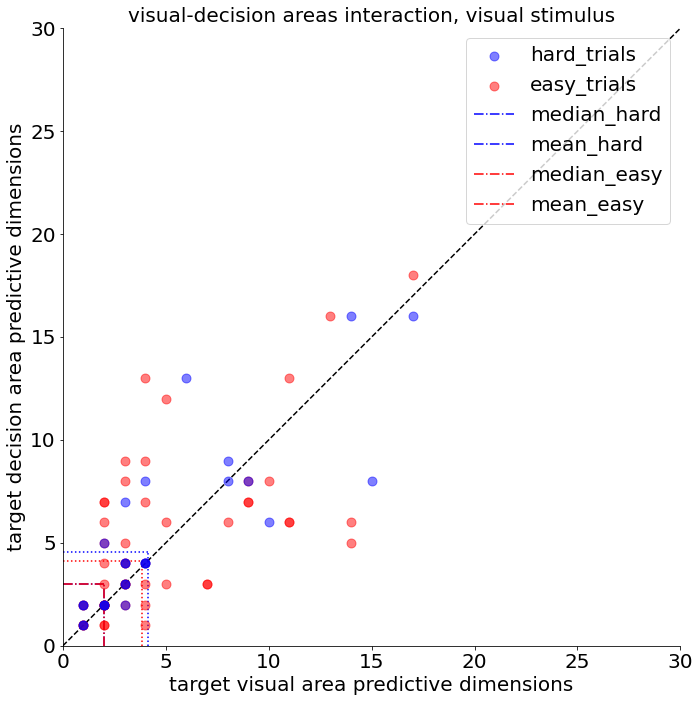

In [ ]:
hard_trial_vv_vd, easy_trial_vv_vd = hard_easy_trial(predictive_dimension_all_vv_vd)
median_value_hard_vv_vd, median_value_easy_vv_vd = some_stat(hard_trial_vv_vd, easy_trial_vv_vd)
mean_value_hard_vv_vd, mean_value_easy_vv_vd = mean_value(hard_trial_vv_vd, easy_trial_vv_vd)

x = np.linspace(0,30)
y = x

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(hard_trial_vv_vd[:,0]+1,hard_trial_vv_vd[:,1]+1, s = 80, alpha = 0.5, color='b', zorder = 20)
ax.scatter(easy_trial_vv_vd[:,0]+1,easy_trial_vv_vd[:,1]+1, s = 80, alpha = 0.5,color='r', zorder = 10)
plt.plot(x,y,'k--', zorder = 1, label = '_nolegend_')
plt.vlines(median_value_hard_vv_vd[0],0,median_value_hard_vv_vd[1], 'b', 'dashdot')
plt.hlines(median_value_hard_vv_vd[1],0, median_value_hard_vv_vd[0], 'b', 'dashdot')
plt.vlines(median_value_easy_vv_vd[0],0,median_value_easy_vv_vd[1], 'r', 'dashdot')
plt.hlines(median_value_easy_vv_vd[1],0, median_value_easy_vv_vd[0], 'r', 'dashdot')
plt.vlines(mean_value_hard_vv_vd[0],0,mean_value_hard_vv_vd[1], 'b', 'dotted')
plt.hlines(mean_value_hard_vv_vd[1],0, mean_value_hard_vv_vd[0], 'b', 'dotted')
plt.vlines(mean_value_easy_vv_vd[0],0,mean_value_easy_vv_vd[1], 'r', 'dotted')
plt.hlines(mean_value_easy_vv_vd[1],0, mean_value_easy_vv_vd[0], 'r', 'dotted')
plt.xlim(0,30)
plt.ylim(0,30)
ax.set_aspect('equal','box')
ax.set_xlabel('target visual area predictive dimensions', fontsize = 20)
ax.set_ylabel('target decision area predictive dimensions',fontsize = 20)
plt.legend(('hard_trials','easy_trials','median_hard', 'mean_hard', 'median_easy', 'mean_easy'),
           loc='upper right', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20)
plt.title('visual-decision areas interaction, visual stimulus', fontsize = 20)


plt.show()

In [ ]:
#@title Loop over all sessions and brain area groups to perform ridge regression and reduced rank regression for each group (visual_visual)

visual_primary  = np.array(('VISp'))
visual_secondary= np.array(('VISa','VISam','VISl','VISpm','VISrl'))
visual_group    = np.array(('VISa','VISam','VISl','VISp','VISpm','VISrl')) # Note - set to 'all' to retrieve all areas
frontal_group   = np.array(('ACA', 'ORB', 'MOp', 'MOs'))
motor_group     = np.array(('MOp', 'MOs'))
decision_group  = np.array(('ACA', 'ORB', 'CP'))
all_areas_group = np.array(('all'))

area_array      = np.array([all_areas_group, visual_group, motor_group, decision_group])
area_list       = np.array(['All', 'Visual', 'Motor', 'Decision'])


# How many 10ms spike bins for each type of event
n_bins        = 30

# bins cascade from here
spont_bins    = range(n_bins)
visual_bins   = range(50,n_bins+50)
n_cue_bins    = n_bins
n_resp_bins   = n_bins
n_rew_bins    = n_bins

n_area_groups = area_array.shape[0]
n_sessions    = alldat.shape[0]


# Loop over all sessions
#for i in range(2,3):

predictive_dimension_all_pv_sv = []


for i in range(n_sessions):
  session_data = alldat[i]
  
  go_cue          = alldat[i]['gocue']
  response_time  = alldat[i]['response_time']
  feedback_time = alldat[i]['feedback_time']


  spike_to_test = np.array(('correct_50_100_spikes','correct_25_50_spikes','correct_1_spikes','correct_0_50_spikes','correct_25_100_spikes','correct_0_25_spikes'))
  
  predictive_dimension_session_pv_sv = []

  #for j in range(1):
  for j in range(len(spike_to_test)):
    #spike_name = spike_to_test[j]
    #location_name = 
    spikes_data = session_data[spike_to_test[j]]

    spont_spikes  = spikes_data[:,:,spont_bins] # Only include bins until the visual stimulus
    visual_spikes = spikes_data[:,:,visual_bins] # Spikes in 300ms following vis stimulus
    go_cue_spikes = align_spikes_to_events(spikes_data, go_cue, n_cue_bins)
    resp_spikes   = align_spikes_to_events(spikes_data, response_time, n_resp_bins)
    rew_spikes    = align_spikes_to_events(spikes_data, feedback_time, n_rew_bins)

    #for primary visual and secondary visual interaction


    spike_primary_area = visual_spikes[np.isin(session_data['brain_area'],visual_primary)]
    spike_secondary_area = visual_spikes[np.isin(session_data['brain_area'],visual_secondary)]

    if spike_primary_area.size != 0 and spike_secondary_area.size != 0:

      spike_primary_area_PSTH_subtracted = PSTH_subtract(spike_primary_area)
      spike_secondary_area_PSTH_subtracted = PSTH_subtract(spike_secondary_area)

      RR_score_repeat_PV = []
      RRR_score_repeat_PV = []
      RR_score_repeat_SV = []
      RRR_score_repeat_SV = []

      np.random.seed(42)

      for repeat in range(10):

        #divide into source and target
        primary_source, primary_target, secondary_target = divide_source_target(spike_primary_area_PSTH_subtracted, spike_secondary_area_PSTH_subtracted)
     
        #primary source primary target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_primary_primary, best_alpha_pv = full_ridge_regression(primary_source, primary_target)
        RR_score_repeat_PV.append(ridge_regression_primary_primary)

        #primary source secondary target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_primary_secondary, best_alpha_sv = full_ridge_regression(primary_source, secondary_target)
        RR_score_repeat_SV.append(ridge_regression_primary_secondary)

        #primary source primary target reduced rank regression
        RRR_score_PV = np.ones(len(range(50)))
        for rank in range(50):
          RRR_score_PV[rank] = reduced_rank_regression(primary_source,primary_target,rank = rank, reg = best_alpha_pv)
        RRR_score_repeat_PV.append(RRR_score_PV)

        #primary source secondary target reduced rank regression
        RRR_score_SV = np.ones(len(range(50)))
        for rank in range(50):
          RRR_score_SV[rank] = reduced_rank_regression(primary_source,secondary_target,rank = rank, reg = best_alpha_sv)
        RRR_score_repeat_SV.append(RRR_score_SV)
      

      RR_score_repeat_PV = np.array(RR_score_repeat_PV)
      RRR_score_repeat_PV = np.array(RRR_score_repeat_PV)
      RR_score_repeat_SV = np.array(RR_score_repeat_SV)
      RRR_score_repeat_SV = np.array(RRR_score_repeat_SV)

      peak_performance_pv = np.mean(RR_score_repeat_PV)
      reduced_rank_regression_pv_score = np.mean(RRR_score_repeat_PV, axis = 0)
      peak_performance_sv = np.mean(RR_score_repeat_SV)
      reduced_rank_regression_sv_score = np.mean(RRR_score_repeat_SV, axis = 0)

      sem_performance_pv = np.std(RR_score_repeat_PV)
      sem_performance_sv = np.std(RR_score_repeat_SV)

          
      predictive_dimension_pv_rrr = predictive_dimension(reduced_rank_regression_pv_score, peak_performance_pv, sem_performance_pv)

          
      predictive_dimension_sv_rrr = predictive_dimension(reduced_rank_regression_sv_score, peak_performance_sv, sem_performance_sv)


          
      predictive_dimension_session_pv_sv.append([predictive_dimension_pv_rrr, predictive_dimension_sv_rrr])
  predictive_dimension_all_pv_sv.append(predictive_dimension_session_pv_sv)

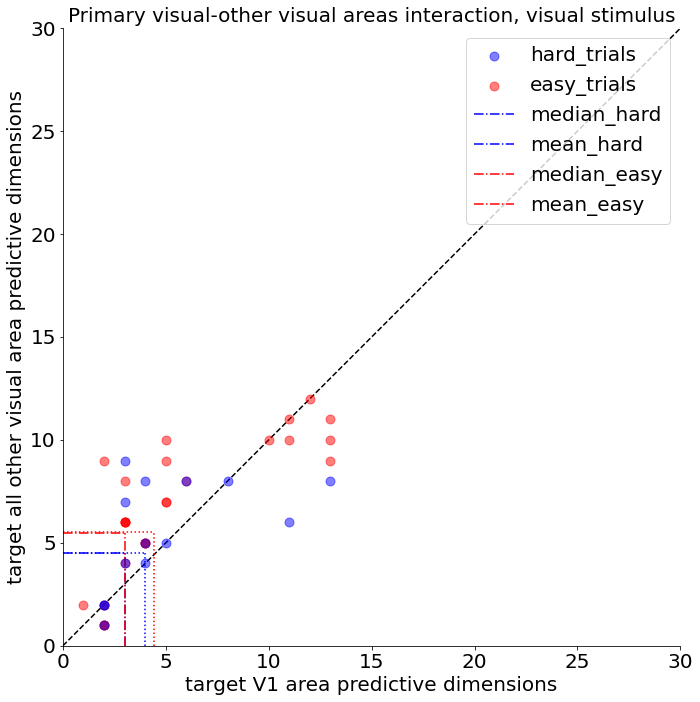

In [ ]:
hard_trial_pv_sv, easy_trial_pv_sv = hard_easy_trial(predictive_dimension_all_pv_sv)
median_value_hard_pv_sv, median_value_easy_pv_sv = some_stat(hard_trial_pv_sv, easy_trial_pv_sv)
mean_value_hard_pv_sv, mean_value_easy_pv_sv = mean_value(hard_trial_pv_sv, easy_trial_pv_sv)
x = np.linspace(0,30)
y = x

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(hard_trial_pv_sv[:,0]+1,hard_trial_pv_sv[:,1]+1, s = 80, alpha = 0.5, color='b', zorder = 20)
ax.scatter(easy_trial_pv_sv[:,0]+1,easy_trial_pv_sv[:,1]+1, s = 80, alpha = 0.5, color='r', zorder = 10)
plt.plot(x,y,'k--', zorder = 1, label = '_nolegend_')
plt.vlines(median_value_hard_pv_sv[0],0,median_value_hard_pv_sv[1], 'b', 'dashdot')
plt.hlines(median_value_hard_pv_sv[1],0, median_value_hard_pv_sv[0], 'b', 'dashdot')
plt.vlines(median_value_easy_pv_sv[0],0,median_value_easy_pv_sv[1], 'r', 'dashdot')
plt.hlines(median_value_easy_pv_sv[1],0, median_value_easy_pv_sv[0], 'r', 'dashdot')
plt.vlines(mean_value_hard_pv_sv[0],0,mean_value_hard_pv_sv[1], 'b', 'dotted')
plt.hlines(mean_value_hard_pv_sv[1],0, mean_value_hard_pv_sv[0], 'b', 'dotted')
plt.vlines(mean_value_easy_pv_sv[0],0,mean_value_easy_pv_sv[1], 'r', 'dotted')
plt.hlines(mean_value_easy_pv_sv[1],0, mean_value_easy_pv_sv[0], 'r', 'dotted')
plt.xlim(0,30)
plt.ylim(0,30)
ax.set_aspect('equal','box')
ax.set_xlabel('target V1 area predictive dimensions', fontsize = 20)
ax.set_ylabel('target all other visual area predictive dimensions', fontsize = 20)
plt.legend(('hard_trials','easy_trials','median_hard', 'mean_hard', 'median_easy', 'mean_easy'),
           loc='upper right', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20)
plt.title('Primary visual-other visual areas interaction, visual stimulus', fontsize = 20)

plt.show()

In [ ]:
#@title Loop over all sessions and brain area groups to perform ridge regression and reduced rank regression for each group (VISp & VISa)

visual_primary  = np.array(('VISp'))
visual_anterior = np.array(('VISa'))

# How many 10ms spike bins for each type of event
n_bins        = 30

# bins cascade from here
visual_bins   = range(50,n_bins+50)

n_sessions    = alldat.shape[0]


# Loop over all sessions

predictive_dimension_all_visp_visa = []


for i in range(n_sessions):
  session_data = alldat[i]

  spike_to_test = np.array(('correct_50_100_spikes','correct_25_50_spikes','correct_1_spikes','correct_0_50_spikes','correct_25_100_spikes','correct_0_25_spikes'))
  
  predictive_dimension_session_visp_visa = []

  for j in range(len(spike_to_test)):

    spikes_data = session_data[spike_to_test[j]]

    visual_spikes = spikes_data[:,:,visual_bins] # Spikes in 300ms following vis stimulus
    
    #for VISp and VISa interaction


    spike_visp_area = visual_spikes[np.isin(session_data['brain_area'],visual_primary)]
    spike_visa_area = visual_spikes[np.isin(session_data['brain_area'],visual_anterior)]

    if spike_visp_area.size != 0 and spike_visa_area.size != 0:

      spike_visp_area_PSTH_subtracted = PSTH_subtract(spike_visp_area)
      spike_visa_area_PSTH_subtracted = PSTH_subtract(spike_visa_area)

      RR_score_repeat_pp= []
      RRR_score_repeat_pp = []
      RR_score_repeat_pa = []
      RRR_score_repeat_pa = []

      np.random.seed(42)

      for repeat in range(10):

        #np.random.seed(42)

        #divide into source and target
        visp_source, visp_target, visa_target = divide_source_target(spike_visp_area_PSTH_subtracted, spike_visa_area_PSTH_subtracted)
     
        #visp source visp target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_visp_visp, best_alpha_pp = full_ridge_regression(visp_source, visp_target)
        RR_score_repeat_pp.append(ridge_regression_visp_visp)

        #visp source visa target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_visp_visa, best_alpha_pa = full_ridge_regression(visp_source, visa_target)
        RR_score_repeat_pa.append(ridge_regression_visp_visa)

        #visp source visp target reduced rank regression
        RRR_score_pp = np.ones(len(range(15)))
        for rank in range(15):
          RRR_score_pp[rank] = reduced_rank_regression(visp_source,visp_target,rank = rank, reg = best_alpha_pp)
        RRR_score_repeat_pp.append(RRR_score_pp)

        #visp source visa target reduced rank regression
        RRR_score_pa = np.ones(len(range(15)))
        for rank in range(15):
          RRR_score_pa[rank] = reduced_rank_regression(visp_source,visa_target,rank = rank, reg = best_alpha_pa)
        RRR_score_repeat_pa.append(RRR_score_pa)
      

      RR_score_repeat_pp = np.array(RR_score_repeat_pp)
      RRR_score_repeat_pp = np.array(RRR_score_repeat_pp)
      RR_score_repeat_pa = np.array(RR_score_repeat_pa)
      RRR_score_repeat_pa = np.array(RRR_score_repeat_pa)

      peak_performance_pp = np.mean(RR_score_repeat_pp)
      reduced_rank_regression_pp_score = np.mean(RRR_score_repeat_pp, axis = 0)

      peak_performance_pa = np.mean(RR_score_repeat_pa)
      reduced_rank_regression_pa_score = np.mean(RRR_score_repeat_pa, axis = 0)

      
      sem_performance_pp = np.std(RR_score_repeat_pp)
      sem_performance_pa = np.std(RR_score_repeat_pa)
          
      predictive_dimension_pp_rrr = predictive_dimension(reduced_rank_regression_pp_score, peak_performance_pp, sem_performance_pp )
      predictive_dimension_pa_rrr = predictive_dimension(reduced_rank_regression_pa_score, peak_performance_pa, sem_performance_pa)

          
      predictive_dimension_session_visp_visa.append([predictive_dimension_pp_rrr, predictive_dimension_pa_rrr])
  predictive_dimension_all_visp_visa.append(predictive_dimension_session_visp_visa)


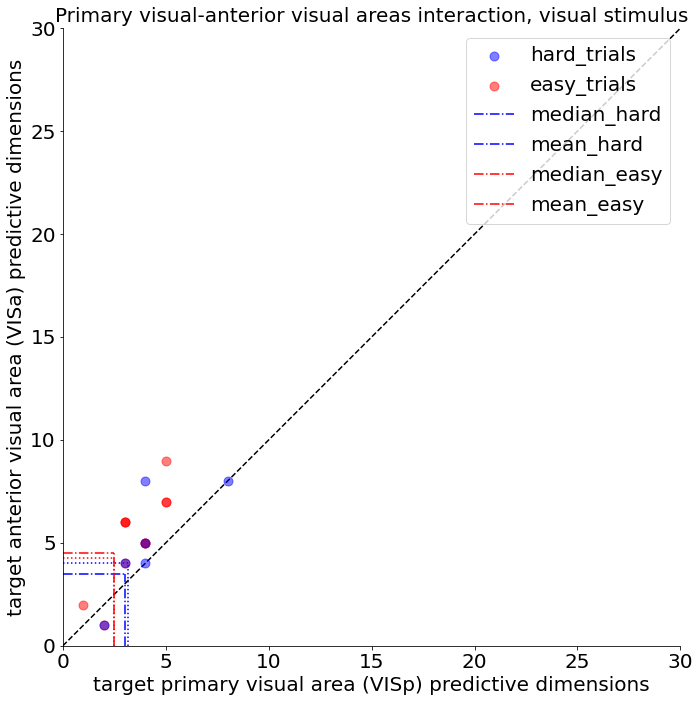

In [ ]:
hard_trial_visp_visa, easy_trial_visp_visa = hard_easy_trial(predictive_dimension_all_visp_visa)
median_value_hard_visp_visa, median_value_easy_visp_visa = some_stat(hard_trial_visp_visa, easy_trial_visp_visa)
mean_value_hard_visp_visa, mean_value_easy_visp_visa = mean_value(hard_trial_visp_visa, easy_trial_visp_visa)
x = np.linspace(0,30)
y = x

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(hard_trial_visp_visa[:,0]+1,hard_trial_visp_visa[:,1]+1, s = 80, alpha = 0.5, color='b', zorder = 20)
ax.scatter(easy_trial_visp_visa[:,0]+1,easy_trial_visp_visa[:,1]+1, s = 80, alpha = 0.5, color='r', zorder = 10)
plt.plot(x,y,'k--', zorder = 1, label = '_nolegend_')
plt.vlines(median_value_hard_visp_visa[0],0,median_value_hard_visp_visa[1], 'b', 'dashdot')
plt.hlines(median_value_hard_visp_visa[1],0, median_value_hard_visp_visa[0], 'b', 'dashdot')
plt.vlines(median_value_easy_visp_visa[0],0,median_value_easy_visp_visa[1], 'r', 'dashdot')
plt.hlines(median_value_easy_visp_visa[1],0, median_value_easy_visp_visa[0], 'r', 'dashdot')
plt.vlines(mean_value_hard_visp_visa[0],0,mean_value_hard_visp_visa[1], 'b', 'dotted')
plt.hlines(mean_value_hard_visp_visa[1],0, mean_value_hard_visp_visa[0], 'b', 'dotted')
plt.vlines(mean_value_easy_visp_visa[0],0,mean_value_easy_visp_visa[1], 'r', 'dotted')
plt.hlines(mean_value_easy_visp_visa[1],0, mean_value_easy_visp_visa[0], 'r', 'dotted')
plt.xlim(0,30)
plt.ylim(0,30)
ax.set_aspect('equal','box')
ax.set_xlabel('target primary visual area (VISp) predictive dimensions', fontsize = 20)
ax.set_ylabel('target anterior visual area (VISa) predictive dimensions', fontsize = 20)
plt.legend(('hard_trials','easy_trials','median_hard', 'mean_hard', 'median_easy', 'mean_easy'),
           loc='upper right', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20)
plt.title('Primary visual-anterior visual areas interaction, visual stimulus', fontsize = 20)

plt.show()

In [ ]:
#@title Loop over all sessions and brain area groups to perform ridge regression and reduced rank regression for each group (VISp & VISam)

visual_primary  = np.array(('VISp'))
visual_anteromedial = np.array(('VISam'))

# How many 10ms spike bins for each type of event
n_bins        = 30

# bins cascade from here
visual_bins   = range(50,n_bins+50)

n_sessions    = alldat.shape[0]


# Loop over all sessions

predictive_dimension_all_visp_visam = []


for i in range(n_sessions):
  session_data = alldat[i]

  spike_to_test = np.array(('correct_50_100_spikes','correct_25_50_spikes','correct_1_spikes','correct_0_50_spikes','correct_25_100_spikes','correct_0_25_spikes'))
  
  predictive_dimension_session_visp_visam = []

  for j in range(len(spike_to_test)):

    spikes_data = session_data[spike_to_test[j]]

    visual_spikes = spikes_data[:,:,visual_bins] # Spikes in 300ms following vis stimulus
    
    #for VISp and VISam interaction


    spike_visp_area = visual_spikes[np.isin(session_data['brain_area'],visual_primary)]
    spike_visam_area = visual_spikes[np.isin(session_data['brain_area'],visual_anteromedial)]

    if spike_visp_area.size != 0 and spike_visam_area.size != 0:

      spike_visp_area_PSTH_subtracted = PSTH_subtract(spike_visp_area)
      spike_visam_area_PSTH_subtracted = PSTH_subtract(spike_visam_area)

      RR_score_repeat_pp= []
      RRR_score_repeat_pp = []
      RR_score_repeat_pam = []
      RRR_score_repeat_pam = []

      np.random.seed(42)

      for repeat in range(10):

        #np.random.seed(42)

        #divide into source and target
        visp_source, visp_target, visam_target = divide_source_target(spike_visp_area_PSTH_subtracted, spike_visam_area_PSTH_subtracted)
     
        #visp source visp target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_visp_visp , best_alpha_pp = full_ridge_regression(visp_source, visp_target)
        RR_score_repeat_pp.append(ridge_regression_visp_visp)

        #visp source visam target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_visp_visam , best_alpha_pam = full_ridge_regression(visp_source, visam_target)
        RR_score_repeat_pam.append(ridge_regression_visp_visam)

        #visp source visp target reduced rank regression
        RRR_score_pp = np.ones(len(range(15)))
        for rank in range(15):
          RRR_score_pp[rank] = reduced_rank_regression(visp_source,visp_target,rank = rank, reg = best_alpha_pp)
        RRR_score_repeat_pp.append(RRR_score_pp)

        #visp source visa target reduced rank regression
        RRR_score_pam = np.ones(len(range(15)))
        for rank in range(15):
          RRR_score_pam[rank] = reduced_rank_regression(visp_source,visam_target,rank = rank, reg = best_alpha_pam)
        RRR_score_repeat_pam.append(RRR_score_pam)
      

      RR_score_repeat_pp = np.array(RR_score_repeat_pp)
      RRR_score_repeat_pp = np.array(RRR_score_repeat_pp)
      RR_score_repeat_pam = np.array(RR_score_repeat_pam)
      RRR_score_repeat_pam = np.array(RRR_score_repeat_pam)

      peak_performance_pp = np.mean(RR_score_repeat_pp)
      reduced_rank_regression_pp_score = np.mean(RRR_score_repeat_pp, axis = 0)

      peak_performance_pam = np.mean(RR_score_repeat_pam)
      reduced_rank_regression_pam_score = np.mean(RRR_score_repeat_pam, axis = 0)

      
      sem_performance_pp = np.std(RR_score_repeat_pp)
      sem_performance_pam = np.std(RR_score_repeat_pam)
          
      predictive_dimension_pp_rrr = predictive_dimension(reduced_rank_regression_pp_score, peak_performance_pp, sem_performance_pp)
      predictive_dimension_pam_rrr = predictive_dimension(reduced_rank_regression_pam_score, peak_performance_pam, sem_performance_pam)


      predictive_dimension_session_visp_visam.append([predictive_dimension_pp_rrr, predictive_dimension_pam_rrr])

  predictive_dimension_all_visp_visam.append(predictive_dimension_session_visp_visam)


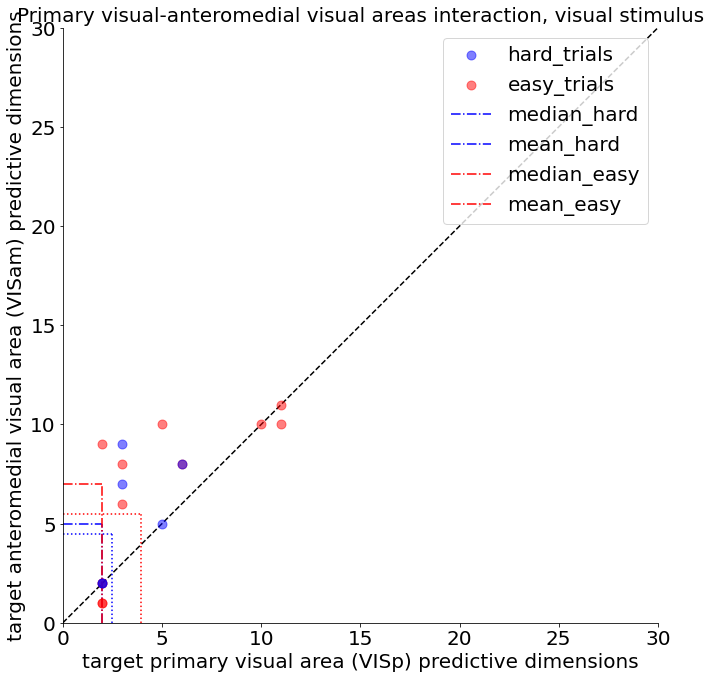

In [ ]:
hard_trial_visp_visam, easy_trial_visp_visam = hard_easy_trial(predictive_dimension_all_visp_visam)

median_value_hard_visp_visam, median_value_easy_visp_visam = some_stat(hard_trial_visp_visam, easy_trial_visp_visam)
mean_value_hard_visp_visam, mean_value_easy_visp_visam = mean_value(hard_trial_visp_visam, easy_trial_visp_visam)

x = np.linspace(0,30)
y = x

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(hard_trial_visp_visam[:,0]+1,hard_trial_visp_visam[:,1]+1, s = 80, alpha = 0.5, color='b', zorder = 20)
ax.scatter(easy_trial_visp_visam[:,0]+1,easy_trial_visp_visam[:,1]+1, s = 80, alpha = 0.5,color='r', zorder = 10)
plt.plot(x,y,'k--', zorder = 1, label = '_nolegend_')
plt.vlines(median_value_hard_visp_visam[0],0,median_value_hard_visp_visam[1], 'b', 'dashdot')
plt.hlines(median_value_hard_visp_visam[1],0, median_value_hard_visp_visam[0], 'b', 'dashdot')
plt.vlines(median_value_easy_visp_visam[0],0,median_value_easy_visp_visam[1], 'r', 'dashdot')
plt.hlines(median_value_easy_visp_visam[1],0, median_value_easy_visp_visam[0], 'r', 'dashdot')
plt.vlines(mean_value_hard_visp_visam[0],0,mean_value_hard_visp_visam[1], 'b', 'dotted')
plt.hlines(mean_value_hard_visp_visam[1],0, mean_value_hard_visp_visam[0], 'b', 'dotted')
plt.vlines(mean_value_easy_visp_visam[0],0, mean_value_easy_visp_visam[1], 'r', 'dotted')
plt.hlines(mean_value_easy_visp_visam[1],0, mean_value_easy_visp_visam[0], 'r', 'dotted')
plt.xlim(0,30)
plt.ylim(0,30)
ax.set_aspect('equal','box')
ax.set_xlabel('target primary visual area (VISp) predictive dimensions', fontsize = 20)
ax.set_ylabel('target anteromedial visual area (VISam) predictive dimensions', fontsize = 20)
plt.legend(('hard_trials','easy_trials','median_hard', 'mean_hard', 'median_easy', 'mean_easy'),
           loc='upper right', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20)
plt.title('Primary visual-anteromedial visual areas interaction, visual stimulus', fontsize = 20)

plt.show()

In [ ]:
#@title Loop over all sessions and brain area groups to perform ridge regression and reduced rank regression for each group (VISp & VISl) - too little trials, didn't perform analysis

visual_primary  = np.array(('VISp'))
visual_lateral = np.array(('VISl'))

# How many 10ms spike bins for each type of event
n_bins        = 30

# bins cascade from here
visual_bins   = range(50,n_bins+50)

n_sessions    = alldat.shape[0]


# Loop over all sessions

predictive_dimension_all_visp_visl = []


for i in range(n_sessions):
  session_data = alldat[i]

  spike_to_test = np.array(('correct_1_spikes','correct_0_50_spikes','correct_50_100_spikes','correct_25_50_spikes','correct_25_100_spikes','correct_0_25_spikes'))
  
  predictive_dimension_session_visp_visl = []

  for j in range(len(spike_to_test)):

    spikes_data = session_data[spike_to_test[j]]

    visual_spikes = spikes_data[:,:,visual_bins] # Spikes in 300ms following vis stimulus
    
    #for VISp and VISl interaction


    spike_visp_area = visual_spikes[np.isin(session_data['brain_area'],visual_primary)]
    spike_visl_area = visual_spikes[np.isin(session_data['brain_area'],visual_lateral)]

    if spike_visp_area.size != 0 and spike_visl_area.size != 0:

      spike_visp_area_PSTH_subtracted = PSTH_subtract(spike_visp_area)
      spike_visl_area_PSTH_subtracted = PSTH_subtract(spike_visl_area)

      RR_score_repeat_pp= []
      RRR_score_repeat_pp = []
      RR_score_repeat_pl = []
      RRR_score_repeat_pl = []

      np.random.seed(42)

      for repeat in range(10):

        #np.random.seed(42)

        #divide into source and target
        visp_source, visp_target, visl_target = divide_source_target(spike_visp_area_PSTH_subtracted, spike_visl_area_PSTH_subtracted)
     
        #visp source visp target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_visp_visp = full_ridge_regression(visp_source, visp_target)
        RR_score_repeat_pp.append(ridge_regression_visp_visp)

        #visp source visl target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_visp_visl = full_ridge_regression(visp_source, visl_target)
        RR_score_repeat_pl.append(ridge_regression_visp_visl)

        #visp source visp target reduced rank regression
        RRR_score_pp = np.ones(len(range(15)))
        for rank in range(15):
          RRR_score_pp[rank] = reduced_rank_regression(visp_source,visp_target,rank = rank)
        RRR_score_repeat_pp.append(RRR_score_pp)

        #visp source visl target reduced rank regression
        RRR_score_pl = np.ones(len(range(15)))
        for rank in range(15):
          RRR_score_pl[rank] = reduced_rank_regression(visp_source,visl_target,rank = rank)
        RRR_score_repeat_pl.append(RRR_score_pl)
      

      RR_score_repeat_pp = np.array(RR_score_repeat_pp)
      RRR_score_repeat_pp = np.array(RRR_score_repeat_pp)
      RR_score_repeat_pl = np.array(RR_score_repeat_pl)
      RRR_score_repeat_pl = np.array(RRR_score_repeat_pl)

      peak_performance_pp = np.mean(RR_score_repeat_pp)
      reduced_rank_regression_pp_score = np.mean(RRR_score_repeat_pp, axis = 0)

      peak_performance_pl = np.mean(RR_score_repeat_pl)
      reduced_rank_regression_pl_score = np.mean(RRR_score_repeat_pl, axis = 0)

      
      sem_performance_pp = np.std(RR_score_repeat_pp)
      sem_performance_pl = np.std(RR_score_repeat_pl)
          
      predictive_dimension_pp_rrr = predictive_dimension(reduced_rank_regression_pp_score, peak_performance_pp, sem_performance_pp )
      predictive_dimension_pl_rrr = predictive_dimension(reduced_rank_regression_pl_score, peak_performance_pl, sem_performance_pl)

          
      predictive_dimension_session_visp_visl.append([predictive_dimension_pp_rrr, predictive_dimension_pl_rrr])
  predictive_dimension_all_visp_visl.append(predictive_dimension_session_visp_visl)


TypeError: ignored

In [ ]:
predictive_dimension_all_visp_visl

In [ ]:
#@title Loop over all sessions and brain area groups to perform ridge regression and reduced rank regression for each group (VISp & VISpm) - too little session, didn't perform analysis

visual_primary  = np.array(('VISp'))
visual_posteromedial = np.array(('VISpm'))

# How many 10ms spike bins for each type of event
n_bins        = 30

# bins cascade from here
visual_bins   = range(50,n_bins+50)

n_sessions    = alldat.shape[0]


# Loop over all sessions

predictive_dimension_all_visp_vispm = []


for i in range(n_sessions):
  session_data = alldat[i]

  spike_to_test = np.array(('correct_1_spikes','correct_0_50_spikes','correct_50_100_spikes','correct_25_50_spikes','correct_25_100_spikes','correct_0_25_spikes'))
  
  predictive_dimension_session_visp_vispm = []

  for j in range(len(spike_to_test)):

    spikes_data = session_data[spike_to_test[j]]

    visual_spikes = spikes_data[:,:,visual_bins] # Spikes in 300ms following vis stimulus
    
    #for VISp and VISpm interaction


    spike_visp_area = visual_spikes[np.isin(session_data['brain_area'],visual_primary)]
    spike_vispm_area = visual_spikes[np.isin(session_data['brain_area'],visual_posteromedial)]

    if spike_visp_area.size != 0 and spike_vispm_area.size != 0:

      spike_visp_area_PSTH_subtracted = PSTH_subtract(spike_visp_area)
      spike_vispm_area_PSTH_subtracted = PSTH_subtract(spike_vispm_area)

      RR_score_repeat_pp= []
      RRR_score_repeat_pp = []
      RR_score_repeat_ppm = []
      RRR_score_repeat_ppm = []

      np.random.seed(42)

      for repeat in range(10):

        #np.random.seed(42)

        #divide into source and target
        visp_source, visp_target, vispm_target = divide_source_target(spike_visp_area_PSTH_subtracted, spike_vispm_area_PSTH_subtracted)
     
        #visp source visp target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_visp_visp = full_ridge_regression(visp_source, visp_target)
        RR_score_repeat_pp.append(ridge_regression_visp_visp)

        #visp source vispm target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_visp_vispm = full_ridge_regression(visp_source, vispm_target)
        RR_score_repeat_ppm.append(ridge_regression_visp_vispm)

        #visp source visp target reduced rank regression
        RRR_score_pp = np.ones(len(range(15)))
        for rank in range(15):
          RRR_score_pp[rank] = reduced_rank_regression(visp_source,visp_target,rank = rank)
        RRR_score_repeat_pp.append(RRR_score_pp)

        #visp source vispm target reduced rank regression
        RRR_score_ppm = np.ones(len(range(15)))
        for rank in range(15):
          RRR_score_ppm[rank] = reduced_rank_regression(visp_source,vispm_target,rank = rank)
        RRR_score_repeat_ppm.append(RRR_score_ppm)
      

      RR_score_repeat_pp = np.array(RR_score_repeat_pp)
      RRR_score_repeat_pp = np.array(RRR_score_repeat_pp)
      RR_score_repeat_ppm = np.array(RR_score_repeat_ppm)
      RRR_score_repeat_ppm = np.array(RRR_score_repeat_ppm)

      peak_performance_pp = np.mean(RR_score_repeat_pp)
      reduced_rank_regression_pp_score = np.mean(RRR_score_repeat_pp, axis = 0)

      peak_performance_ppm = np.mean(RR_score_repeat_ppm)
      reduced_rank_regression_ppm_score = np.mean(RRR_score_repeat_ppm, axis = 0)

      
      sem_performance_pp = np.std(RR_score_repeat_pp)
      sem_performance_ppm = np.std(RR_score_repeat_ppm)
          
      predictive_dimension_pp_rrr = predictive_dimension(reduced_rank_regression_pp_score, peak_performance_pp, sem_performance_pp )
      predictive_dimension_ppm_rrr = predictive_dimension(reduced_rank_regression_ppm_score, peak_performance_ppm, sem_performance_ppm)

          
      predictive_dimension_session_visp_vispm.append([predictive_dimension_pp_rrr, predictive_dimension_ppm_rrr])
  predictive_dimension_all_visp_vispm.append(predictive_dimension_session_visp_vispm)


In [ ]:
predictive_dimension_all_visp_vispm

In [ ]:
#@title Loop over all sessions and brain area groups to perform ridge regression and reduced rank regression for each group (VISp & VISrl) - too little session, didn't perform analysis

visual_primary  = np.array(('VISp'))
visual_rostrolateral = np.array(('VISrl'))

# How many 10ms spike bins for each type of event
n_bins        = 30

# bins cascade from here
visual_bins   = range(50,n_bins+50)

n_sessions    = alldat.shape[0]


# Loop over all sessions

predictive_dimension_all_visp_visrl = []


for i in range(n_sessions):
  session_data = alldat[i]

  spike_to_test = np.array(('correct_1_spikes','correct_0_50_spikes','correct_50_100_spikes','correct_25_50_spikes','correct_25_100_spikes','correct_0_25_spikes'))
  
  predictive_dimension_session_visp_visrl = []

  for j in range(len(spike_to_test)):

    spikes_data = session_data[spike_to_test[j]]

    visual_spikes = spikes_data[:,:,visual_bins] # Spikes in 300ms following vis stimulus
    
    #for VISp and VISrl interaction


    spike_visp_area = visual_spikes[np.isin(session_data['brain_area'],visual_primary)]
    spike_visrl_area = visual_spikes[np.isin(session_data['brain_area'],visual_rostrolateral)]

    if spike_visp_area.size != 0 and spike_visrl_area.size != 0:

      spike_visp_area_PSTH_subtracted = PSTH_subtract(spike_visp_area)
      spike_visrl_area_PSTH_subtracted = PSTH_subtract(spike_visrl_area)

      RR_score_repeat_pp= []
      RRR_score_repeat_pp = []
      RR_score_repeat_prl = []
      RRR_score_repeat_prl = []

      np.random.seed(42)

      for repeat in range(10):

        #np.random.seed(42)

        #divide into source and target
        visp_source, visp_target, visrl_target = divide_source_target(spike_visp_area_PSTH_subtracted, spike_visrl_area_PSTH_subtracted)
     
        #visp source visp target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_visp_visp = full_ridge_regression(visp_source, visp_target)
        RR_score_repeat_pp.append(ridge_regression_visp_visp)

        #visp source visrl target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_visp_visrl = full_ridge_regression(visp_source, visrl_target)
        RR_score_repeat_prl.append(ridge_regression_visp_visrl)

        #visp source visp target reduced rank regression
        RRR_score_pp = np.ones(len(range(15)))
        for rank in range(15):
          RRR_score_pp[rank] = reduced_rank_regression(visp_source,visp_target,rank = rank)
        RRR_score_repeat_pp.append(RRR_score_pp)

        #visp source visrl target reduced rank regression
        RRR_score_prl = np.ones(len(range(15)))
        for rank in range(15):
          RRR_score_prl[rank] = reduced_rank_regression(visp_source,visrl_target,rank = rank)
        RRR_score_repeat_prl.append(RRR_score_prl)
      

      RR_score_repeat_pp = np.array(RR_score_repeat_pp)
      RRR_score_repeat_pp = np.array(RRR_score_repeat_pp)
      RR_score_repeat_prl = np.array(RR_score_repeat_prl)
      RRR_score_repeat_prl = np.array(RRR_score_repeat_prl)

      peak_performance_pp = np.mean(RR_score_repeat_pp)
      reduced_rank_regression_pp_score = np.mean(RRR_score_repeat_pp, axis = 0)

      peak_performance_prl = np.mean(RR_score_repeat_prl)
      reduced_rank_regression_prl_score = np.mean(RRR_score_repeat_prl, axis = 0)

      
      sem_performance_pp = np.std(RR_score_repeat_pp)
      sem_performance_prl = np.std(RR_score_repeat_prl)
          
      predictive_dimension_pp_rrr = predictive_dimension(reduced_rank_regression_pp_score, peak_performance_pp, sem_performance_pp )
      predictive_dimension_prl_rrr = predictive_dimension(reduced_rank_regression_prl_score, peak_performance_prl, sem_performance_prl)

          
      predictive_dimension_session_visp_visrl.append([predictive_dimension_pp_rrr, predictive_dimension_prl_rrr])
  predictive_dimension_all_visp_visrl.append(predictive_dimension_session_visp_visrl)


In [ ]:
predictive_dimension_all_visp_visrl

In [ ]:
#@title Loop over all sessions and brain area groups to perform ridge regression and reduced rank regression for each group (decision_motor)

motor_group     = np.array(('MOp', 'MOs'))
decision_group  = np.array(('ACA', 'ORB', 'CP'))

# How many 10ms spike bins for each type of event
n_bins        = 30

# bins cascade from here

n_cue_bins    = n_bins

n_sessions    = alldat.shape[0]


predictive_dimension_all_dd_dm= []


for i in range(n_sessions):
  session_data = alldat[i]
  
  go_cue          = alldat[i]['gocue']
  response_time  = alldat[i]['response_time']
  feedback_time = alldat[i]['feedback_time']


  spike_to_test = np.array(('correct_50_100_spikes','correct_25_50_spikes','correct_1_spikes','correct_0_50_spikes','correct_25_100_spikes','correct_0_25_spikes'))
  
  predictive_dimension_session_dd_dm = []

  for j in range(len(spike_to_test)):

    spikes_data = session_data[spike_to_test[j]]


    go_cue_spikes = align_spikes_to_events(spikes_data, go_cue, n_cue_bins)

    #for aca-mos interaction

    spike_decision_area = go_cue_spikes[np.isin(session_data['brain_area'],decision_group)]
    spike_motor_area = go_cue_spikes[np.isin(session_data['brain_area'],motor_group)]

    if spike_decision_area.size != 0 and spike_motor_area.size != 0:

      spike_decision_area_PSTH_subtracted = PSTH_subtract(spike_decision_area)
      spike_motor_area_PSTH_subtracted = PSTH_subtract(spike_motor_area)

      RR_score_repeat_DD = []
      RRR_score_repeat_DD= []
      RR_score_repeat_DM = []
      RRR_score_repeat_DM = []

      np.random.seed(42)

      for repeat in range(10):

        #divide into source and target
        decision_source, decision_target, motor_target = divide_source_target(spike_decision_area_PSTH_subtracted, spike_motor_area_PSTH_subtracted)
     
        #decision source decision target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_decision_decision, best_alpha_dd = full_ridge_regression(decision_source, decision_target)
        RR_score_repeat_DD.append(ridge_regression_decision_decision)

        #decision source motor target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_decision_motor, best_alpha_dm = full_ridge_regression(decision_source, motor_target)
        RR_score_repeat_DM.append(ridge_regression_decision_motor)

        #decision source decision target reduced rank regression
        RRR_score_DD = np.ones(len(range(25)))
        for rank in range(25):
          RRR_score_DD[rank] = reduced_rank_regression(decision_source,decision_target,rank = rank, reg = best_alpha_dd)
        RRR_score_repeat_DD.append(RRR_score_DD)

        #decision source motor target reduced rank regression
        RRR_score_DM = np.ones(len(range(25)))
        for rank in range(25):
          RRR_score_DM[rank] = reduced_rank_regression(decision_source,motor_target,rank = rank, reg = best_alpha_dm)
        RRR_score_repeat_DM.append(RRR_score_DM)
      

      RR_score_repeat_DD = np.array(RR_score_repeat_DD)
      RRR_score_repeat_DD = np.array(RRR_score_repeat_DD)
      RR_score_repeat_DM = np.array(RR_score_repeat_DM)
      RRR_score_repeat_DM = np.array(RRR_score_repeat_DM)

      peak_performance_dd = np.mean(RR_score_repeat_DD)
      reduced_rank_regression_dd_score = np.mean(RRR_score_repeat_DD, axis = 0)
      peak_performance_dm = np.mean(RR_score_repeat_DM)
      reduced_rank_regression_dm_score = np.mean(RRR_score_repeat_DM, axis = 0)

      sem_performance_dd = np.std(RR_score_repeat_DD)
      sem_performance_dm = np.std(RR_score_repeat_DM)

          
      predictive_dimension_dd_rrr = predictive_dimension(reduced_rank_regression_dd_score, peak_performance_dd, sem_performance_dd)

          
      predictive_dimension_dm_rrr = predictive_dimension(reduced_rank_regression_dm_score, peak_performance_dm, sem_performance_dm)


          
      predictive_dimension_session_dd_dm.append([predictive_dimension_dd_rrr, predictive_dimension_dm_rrr])
  predictive_dimension_all_dd_dm.append(predictive_dimension_session_dd_dm)

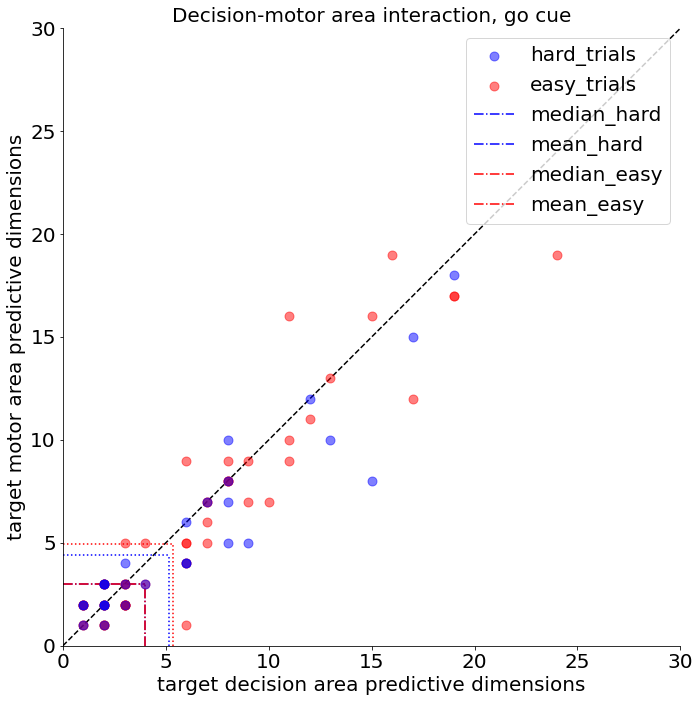

In [ ]:
predictive_dimension_all_dd_dm_filter = np.delete(np.array(predictive_dimension_all_dd_dm),[10,13],0)
hard_trial_dd_dm, easy_trial_dd_dm = hard_easy_trial(predictive_dimension_all_dd_dm_filter)
median_value_hard_dd_dm, median_value_easy_dd_dm = some_stat(hard_trial_dd_dm, easy_trial_dd_dm)
mean_value_hard_dd_dm, mean_value_easy_dd_dm = mean_value(hard_trial_dd_dm, easy_trial_dd_dm)

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(hard_trial_dd_dm[:,0]+1,hard_trial_dd_dm[:,1]+1, s = 80, alpha = 0.5, color='b', zorder = 20)
ax.scatter(easy_trial_dd_dm[:,0]+1,easy_trial_dd_dm[:,1]+1, s = 80, alpha = 0.5, color='r', zorder = 10)
plt.plot(x,y,'k--', zorder = 1, label = '_nolegend_')
plt.vlines(median_value_hard_dd_dm[0],0,median_value_hard_dd_dm[1], 'b', 'dashdot')
plt.hlines(median_value_hard_dd_dm[1],0, median_value_hard_dd_dm[0], 'b', 'dashdot')
plt.vlines(median_value_easy_dd_dm[0],0,median_value_easy_dd_dm[1], 'r', 'dashdot')
plt.hlines(median_value_easy_dd_dm[1],0, median_value_easy_dd_dm[0], 'r', 'dashdot')
plt.vlines(mean_value_hard_dd_dm[0],0,mean_value_hard_dd_dm[1], 'b', 'dotted')
plt.hlines(mean_value_hard_dd_dm[1],0, mean_value_hard_dd_dm[0], 'b', 'dotted')
plt.vlines(mean_value_easy_dd_dm[0],0,mean_value_easy_dd_dm[1], 'r', 'dotted')
plt.hlines(mean_value_easy_dd_dm[1],0, mean_value_easy_dd_dm[0], 'r', 'dotted')
plt.xlim(0,30)
plt.ylim(0,30)
ax.set_aspect('equal','box')
ax.set_xlabel('target decision area predictive dimensions', fontsize = 20)
ax.set_ylabel('target motor area predictive dimensions', fontsize = 20)
plt.legend(('hard_trials','easy_trials','median_hard', 'mean_hard', 'median_easy', 'mean_easy'),
           loc='upper right', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20)
plt.title('Decision-motor area interaction, go cue', fontsize = 20)

plt.show()

In [ ]:
#@title Loop over all sessions and brain area groups to perform ridge regression and reduced rank regression for each group (aca-mos)

anterior_cingulate_area     = np.array(('ACA'))
secondary_motor_area  = np.array(('MOs'))

# How many 10ms spike bins for each type of event
n_bins        = 30

# bins cascade from here

n_cue_bins    = n_bins

n_sessions    = alldat.shape[0]


predictive_dimension_all_aca_mos= []


for i in range(n_sessions):
  session_data = alldat[i]
  
  go_cue          = alldat[i]['gocue']
  response_time  = alldat[i]['response_time']
  feedback_time = alldat[i]['feedback_time']


  spike_to_test = np.array(('correct_50_100_spikes','correct_25_50_spikes','correct_1_spikes','correct_0_50_spikes','correct_25_100_spikes','correct_0_25_spikes'))
  
  predictive_dimension_session_aca_mos = []

  for j in range(len(spike_to_test)):

    spikes_data = session_data[spike_to_test[j]]


    go_cue_spikes = align_spikes_to_events(spikes_data, go_cue, n_cue_bins)

    #for aca-mos interaction

    spike_aca_area = go_cue_spikes[np.isin(session_data['brain_area'],anterior_cingulate_area)]
    spike_mos_area = go_cue_spikes[np.isin(session_data['brain_area'],secondary_motor_area)]

    if spike_aca_area.size != 0 and spike_mos_area.size != 0:

      spike_aca_area_PSTH_subtracted = PSTH_subtract(spike_aca_area)
      spike_mos_area_PSTH_subtracted = PSTH_subtract(spike_mos_area)

      RR_score_repeat_ACAACA = []
      RRR_score_repeat_ACAACA= []
      RR_score_repeat_ACAMOS = []
      RRR_score_repeat_ACAMOS = []

      np.random.seed(42)

      for repeat in range(10):

        #divide into source and target
        aca_source, aca_target, mos_target = divide_source_target(spike_aca_area_PSTH_subtracted, spike_mos_area_PSTH_subtracted)
     
        #aca source aca target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_aca_aca, best_alpha_acaaca = full_ridge_regression(aca_source, aca_target)
        RR_score_repeat_ACAACA.append(ridge_regression_aca_aca)

        #aca source mos target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_aca_mos, best_alpha_acamos = full_ridge_regression(aca_source, mos_target)
        RR_score_repeat_ACAMOS.append(ridge_regression_aca_mos)

        #aca source aca target reduced rank regression
        RRR_score_ACAACA = np.ones(len(range(25)))
        for rank in range(25):
          RRR_score_ACAACA[rank] = reduced_rank_regression(aca_source,aca_target,rank = rank, reg = best_alpha_acaaca)
        RRR_score_repeat_ACAACA.append(RRR_score_ACAACA)

        #aca source mos target reduced rank regression
        RRR_score_ACAMOS = np.ones(len(range(25)))
        for rank in range(25):
          RRR_score_ACAMOS[rank] = reduced_rank_regression(aca_source,mos_target,rank = rank, reg = best_alpha_acamos)
        RRR_score_repeat_ACAMOS.append(RRR_score_ACAMOS)
      

      RR_score_repeat_ACAACA = np.array(RR_score_repeat_ACAACA)
      RRR_score_repeat_ACAACA = np.array(RRR_score_repeat_ACAACA)
      RR_score_repeat_ACAMOS = np.array(RR_score_repeat_ACAMOS)
      RRR_score_repeat_ACAMOS = np.array(RRR_score_repeat_ACAMOS)

      peak_performance_acaaca = np.mean(RR_score_repeat_ACAACA)
      reduced_rank_regression_acaaca_score = np.mean(RRR_score_repeat_ACAACA, axis = 0)
      peak_performance_acamos = np.mean(RR_score_repeat_ACAMOS)
      reduced_rank_regression_acamos_score = np.mean(RRR_score_repeat_ACAMOS, axis = 0)

      sem_performance_acaaca = np.std(RR_score_repeat_ACAACA)
      sem_performance_acamos = np.std(RR_score_repeat_ACAMOS)

          
      predictive_dimension_acaaca_rrr = predictive_dimension(reduced_rank_regression_acaaca_score, peak_performance_acaaca, sem_performance_acaaca)

          
      predictive_dimension_acamos_rrr = predictive_dimension(reduced_rank_regression_acamos_score, peak_performance_acamos, sem_performance_acamos)


          
      predictive_dimension_session_aca_mos.append([predictive_dimension_acaaca_rrr, predictive_dimension_acamos_rrr])
  predictive_dimension_all_aca_mos.append(predictive_dimension_session_aca_mos)

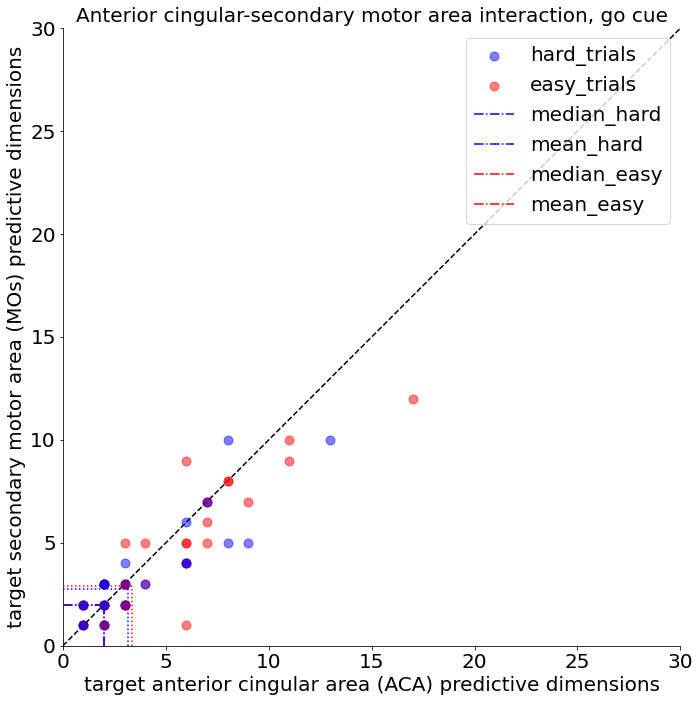

In [ ]:
hard_trial_aca_mos, easy_trial_aca_mos = hard_easy_trial(predictive_dimension_all_aca_mos)
median_value_hard_aca_mos, median_value_easy_aca_mos = some_stat(hard_trial_aca_mos, easy_trial_aca_mos)
mean_value_hard_aca_mos, mean_value_easy_aca_mos = mean_value(hard_trial_aca_mos, easy_trial_aca_mos)
x = np.linspace(0,30)
y = x

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(hard_trial_aca_mos[:,0]+1,hard_trial_aca_mos[:,1]+1, s = 80, alpha = 0.5, color='b', zorder = 20)
ax.scatter(easy_trial_aca_mos[:,0]+1,easy_trial_aca_mos[:,1]+1, s = 80, alpha = 0.5, color='r', zorder = 10)
plt.plot(x,y,'k--', zorder = 1, label = '_nolegend_')
plt.vlines(median_value_hard_aca_mos[0],0,median_value_hard_aca_mos[1], 'b', 'dashdot', zorder = 9)
plt.hlines(median_value_hard_aca_mos[1],0, median_value_hard_aca_mos[0], 'b', 'dashdot', zorder = 9)
plt.vlines(median_value_easy_aca_mos[0],0,median_value_easy_aca_mos[1], 'r', 'dashdot',zorder = 7 )
plt.hlines(median_value_easy_aca_mos[1],0, median_value_easy_aca_mos[0], 'r', 'dashdot',zorder = 7)
plt.vlines(mean_value_hard_aca_mos[0],0,mean_value_hard_aca_mos[1], 'b', 'dotted',zorder = 8)
plt.hlines(mean_value_hard_aca_mos[1],0, mean_value_hard_aca_mos[0], 'b', 'dotted',zorder = 8)
plt.vlines(mean_value_easy_aca_mos[0],0,mean_value_easy_aca_mos[1], 'r', 'dotted',zorder = 6)
plt.hlines(mean_value_easy_aca_mos[1],0, mean_value_easy_aca_mos[0], 'r', 'dotted', zorder = 6)
plt.xlim(0,30)
plt.ylim(0,30)
ax.set_aspect('equal','box')
ax.set_xlabel('target anterior cingular area (ACA) predictive dimensions', fontsize = 20)
ax.set_ylabel('target secondary motor area (MOs) predictive dimensions', fontsize = 20)
plt.legend(('hard_trials','easy_trials','median_hard','mean_hard', 'median_easy', 'mean_easy'),
           loc='upper right', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20)
plt.title('Anterior cingular-secondary motor area interaction, go cue', fontsize = 20)

plt.show()

In [ ]:
#@title Loop over all sessions and brain area groups to perform ridge regression and reduced rank regression for each group (orb-mos)

orbital_area     = np.array(('ORB'))
secondary_motor_area  = np.array(('MOs'))

# How many 10ms spike bins for each type of event
n_bins        = 30

# bins cascade from here

n_cue_bins    = n_bins

n_sessions    = alldat.shape[0]


predictive_dimension_all_orb_mos= []


for i in range(n_sessions):
  session_data = alldat[i]
  
  go_cue          = alldat[i]['gocue']
  response_time  = alldat[i]['response_time']
  feedback_time = alldat[i]['feedback_time']


  spike_to_test = np.array(('correct_50_100_spikes','correct_25_50_spikes', 'correct_1_spikes','correct_0_50_spikes','correct_25_100_spikes','correct_0_25_spikes'))
  
  predictive_dimension_session_orb_mos = []

  for j in range(len(spike_to_test)):

    spikes_data = session_data[spike_to_test[j]]


    go_cue_spikes = align_spikes_to_events(spikes_data, go_cue, n_cue_bins)

    #for aca-mos interaction

    spike_orb_area = go_cue_spikes[np.isin(session_data['brain_area'],orbital_area)]
    spike_mos_area = go_cue_spikes[np.isin(session_data['brain_area'],secondary_motor_area)]

    if spike_orb_area.size != 0 and spike_mos_area.size != 0:

      spike_orb_area_PSTH_subtracted = PSTH_subtract(spike_orb_area)
      spike_mos_area_PSTH_subtracted = PSTH_subtract(spike_mos_area)

      RR_score_repeat_ORBORB = []
      RRR_score_repeat_ORBORB= []
      RR_score_repeat_ORBMOS = []
      RRR_score_repeat_ORBMOS = []

      np.random.seed(42)

      for repeat in range(10):

        #divide into source and target
        orb_source, orb_target, mos_target = divide_source_target(spike_orb_area_PSTH_subtracted, spike_mos_area_PSTH_subtracted)
     
        #orb source orb target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_orb_orb, best_alpha_orborb = full_ridge_regression(orb_source, orb_target)
        RR_score_repeat_ORBORB.append(ridge_regression_orb_orb)

        #orb source mos target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_orb_mos, best_alpha_orbmos = full_ridge_regression(orb_source, mos_target)
        RR_score_repeat_ORBMOS.append(ridge_regression_orb_mos)

        #orb source orb target reduced rank regression
        RRR_score_ORBORB = np.ones(len(range(25)))
        for rank in range(25):
          RRR_score_ORBORB[rank] = reduced_rank_regression(orb_source,orb_target,rank = rank, reg = best_alpha_orborb)
        RRR_score_repeat_ORBORB.append(RRR_score_ORBORB)

        #orb source mos target reduced rank regression
        RRR_score_ORBMOS = np.ones(len(range(25)))
        for rank in range(25):
          RRR_score_ORBMOS[rank] = reduced_rank_regression(orb_source,mos_target,rank = rank, reg = best_alpha_orbmos)
        RRR_score_repeat_ORBMOS.append(RRR_score_ORBMOS)
      

      RR_score_repeat_ORBORB = np.array(RR_score_repeat_ORBORB)
      RRR_score_repeat_ORBORB = np.array(RRR_score_repeat_ORBORB)
      RR_score_repeat_ORBMOS = np.array(RR_score_repeat_ORBMOS)
      RRR_score_repeat_ORBMOS = np.array(RRR_score_repeat_ORBMOS)

      peak_performance_orborb = np.mean(RR_score_repeat_ORBORB)
      reduced_rank_regression_orborb_score = np.mean(RRR_score_repeat_ORBORB, axis = 0)
      peak_performance_orbmos = np.mean(RR_score_repeat_ORBMOS)
      reduced_rank_regression_orbmos_score = np.mean(RRR_score_repeat_ORBMOS, axis = 0)

      sem_performance_orborb = np.std(RR_score_repeat_ORBORB)
      sem_performance_orbmos = np.std(RR_score_repeat_ORBMOS)

          
      predictive_dimension_orborb_rrr = predictive_dimension(reduced_rank_regression_orborb_score, peak_performance_orborb, sem_performance_orborb)

          
      predictive_dimension_orbmos_rrr = predictive_dimension(reduced_rank_regression_orbmos_score, peak_performance_orbmos, sem_performance_orbmos)


          
      predictive_dimension_session_orb_mos.append([predictive_dimension_orborb_rrr, predictive_dimension_orbmos_rrr])
  predictive_dimension_all_orb_mos.append(predictive_dimension_session_orb_mos)

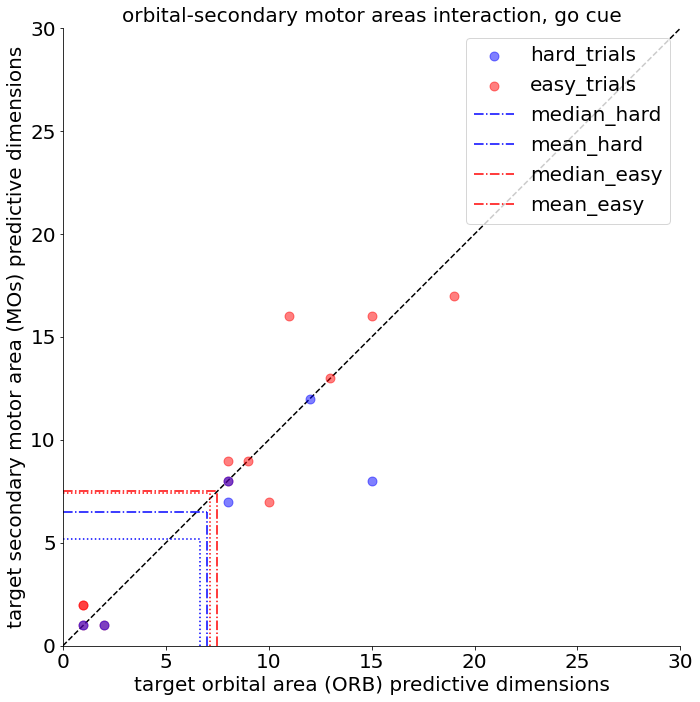

In [ ]:
predictive_dimension_all_orb_mos_filter = np.delete(np.array(predictive_dimension_all_orb_mos),[13,30],0)

hard_trial_orb_mos, easy_trial_orb_mos = hard_easy_trial(predictive_dimension_all_orb_mos_filter)
median_value_hard_orb_mos, median_value_easy_orb_mos = some_stat(hard_trial_orb_mos, easy_trial_orb_mos)
mean_value_hard_orb_mos, mean_value_easy_orb_mos = mean_value(hard_trial_orb_mos, easy_trial_orb_mos)

x = np.linspace(0,30)
y = x

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(hard_trial_orb_mos[:,0]+1,hard_trial_orb_mos[:,1]+1, s = 80, alpha = 0.5, color='b', zorder = 20)
ax.scatter(easy_trial_orb_mos[:,0]+1,easy_trial_orb_mos[:,1]+1, s = 80, alpha = 0.5,  color='r', zorder = 10)
plt.plot(x,y,'k--', zorder = 1, label = '_nolegend_')
plt.vlines(median_value_hard_orb_mos[0],0,median_value_hard_orb_mos[1], 'b', 'dashdot')
plt.hlines(median_value_hard_orb_mos[1],0, median_value_hard_orb_mos[0], 'b', 'dashdot')
plt.vlines(median_value_easy_orb_mos[0],0,median_value_easy_orb_mos[1], 'r', 'dashdot')
plt.hlines(median_value_easy_orb_mos[1],0, median_value_easy_orb_mos[0], 'r', 'dashdot')
plt.vlines(mean_value_hard_orb_mos[0],0,mean_value_hard_orb_mos[1], 'b', 'dotted')
plt.hlines(mean_value_hard_orb_mos[1],0, mean_value_hard_orb_mos[0], 'b', 'dotted')
plt.vlines(mean_value_easy_orb_mos[0],0,mean_value_easy_orb_mos[1], 'r', 'dotted')
plt.hlines(mean_value_easy_orb_mos[1],0, mean_value_easy_orb_mos[0], 'r', 'dotted')
plt.xlim(0,30)
plt.ylim(0,30)
ax.set_aspect('equal','box')
ax.set_xlabel('target orbital area (ORB) predictive dimensions', fontsize = 20)
ax.set_ylabel('target secondary motor area (MOs) predictive dimensions', fontsize = 20)
plt.legend(('hard_trials','easy_trials','median_hard', 'mean_hard', 'median_easy', 'mean_easy'),
           loc='upper right', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20)
plt.title('orbital-secondary motor areas interaction, go cue', fontsize = 20)

plt.show()

In [ ]:
#@title Loop over all sessions and brain area groups to perform ridge regression and reduced rank regression for each group (hippocampal_decision)


decision_group  = np.array(('ACA', 'ORB', 'CP'))
hippocampal_group = np.array(("CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"))




# How many 10ms spike bins for each type of event
n_bins        = 30

# bins cascade from here

n_cue_bins    = n_bins

n_sessions    = alldat.shape[0]


predictive_dimension_all_hh_hd = []


for i in range(n_sessions):
  session_data = alldat[i]
  
  go_cue          = alldat[i]['gocue']
  response_time  = alldat[i]['response_time']
  feedback_time = alldat[i]['feedback_time']


  spike_to_test = np.array(('correct_50_100_spikes','correct_25_50_spikes','correct_1_spikes','correct_0_50_spikes','correct_25_100_spikes','correct_0_25_spikes'))
  
  predictive_dimension_session_hh_hd = []

  for j in range(len(spike_to_test)):

    spikes_data = session_data[spike_to_test[j]]

    go_cue_spikes = align_spikes_to_events(spikes_data, go_cue, n_cue_bins)

    #for hippocampal-decision interaction


    spike_hippocampal_area = go_cue_spikes[np.isin(session_data['brain_area'],hippocampal_group)]
    spike_decision_area = go_cue_spikes[np.isin(session_data['brain_area'],decision_group)]

    if spike_hippocampal_area.size != 0 and spike_decision_area.size != 0:

      spike_hippocampal_area_PSTH_subtracted = PSTH_subtract(spike_hippocampal_area)
      spike_decision_area_PSTH_subtracted = PSTH_subtract(spike_decision_area)

      RR_score_repeat_HH = []
      RRR_score_repeat_HH = []
      RR_score_repeat_HD = []
      RRR_score_repeat_HD = []

      np.random.seed(42)

      for repeat in range(10):

        #divide into source and target
        hippo_source, hippo_target, decision_target = divide_source_target(spike_hippocampal_area_PSTH_subtracted, spike_decision_area_PSTH_subtracted)
     
        #hippo source hippo target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_hippo_hippo, best_alpha_hh = full_ridge_regression(hippo_source, hippo_target)
        RR_score_repeat_HH.append(ridge_regression_hippo_hippo)

        #hippo source decision target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_hippo_decision, best_alpha_hd = full_ridge_regression(hippo_source, decision_target)
        RR_score_repeat_HD.append(ridge_regression_hippo_decision)

        #hippo source hippo target reduced rank regression
        RRR_score_HH = np.ones(len(range(25)))
        for rank in range(25):
          RRR_score_HH[rank] = reduced_rank_regression(hippo_source,hippo_target,rank = rank, reg = best_alpha_hh)
        RRR_score_repeat_HH.append(RRR_score_HH)

        #visual source visual target reduced rank regression
        RRR_score_HD = np.ones(len(range(25)))
        for rank in range(25):
          RRR_score_HD[rank] = reduced_rank_regression(hippo_source,decision_target,rank = rank, reg = best_alpha_hd)
        RRR_score_repeat_HD.append(RRR_score_HD)
      

      RR_score_repeat_HH = np.array(RR_score_repeat_HH)
      RRR_score_repeat_HH = np.array(RRR_score_repeat_HH)
      RR_score_repeat_HD = np.array(RR_score_repeat_HD)
      RRR_score_repeat_HD = np.array(RRR_score_repeat_HD)

      peak_performance_hh = np.mean(RR_score_repeat_HH)
      reduced_rank_regression_hh_score = np.mean(RRR_score_repeat_HH, axis = 0)
      peak_performance_hd = np.mean(RR_score_repeat_HD)
      reduced_rank_regression_hd_score = np.mean(RRR_score_repeat_HD, axis = 0)

      sem_performance_hh = np.std(RR_score_repeat_HH)
      sem_performance_hd = np.std(RR_score_repeat_HD)

          
      predictive_dimension_hh_rrr = predictive_dimension(reduced_rank_regression_hh_score, peak_performance_hh, sem_performance_hh)

          
      predictive_dimension_hd_rrr = predictive_dimension(reduced_rank_regression_hd_score, peak_performance_hd, sem_performance_hd)


          
      predictive_dimension_session_hh_hd.append([predictive_dimension_hh_rrr, predictive_dimension_hd_rrr])
  predictive_dimension_all_hh_hd.append(predictive_dimension_session_hh_hd)

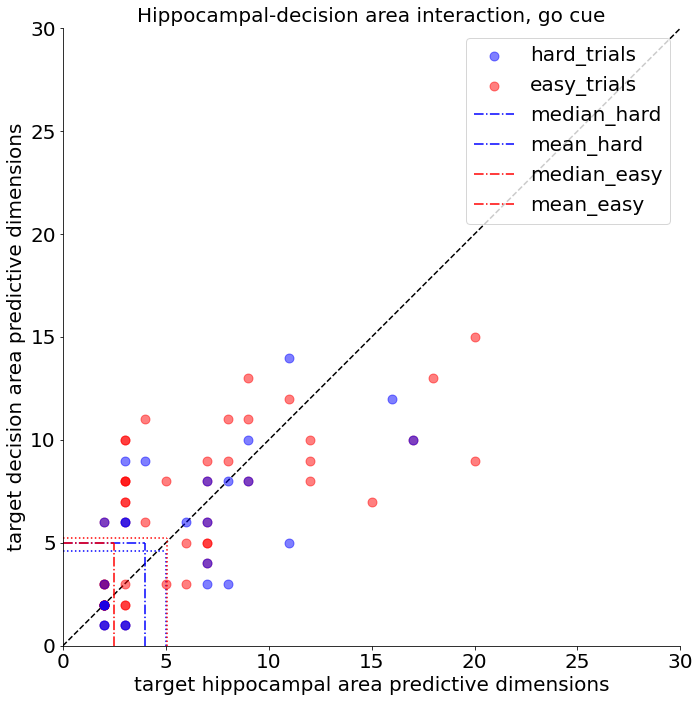

In [ ]:
predictive_dimension_all_hh_hd_filter = np.delete(np.array(predictive_dimension_all_hh_hd),[3],0)
hard_trial_hh_hd, easy_trial_hh_hd = hard_easy_trial(predictive_dimension_all_hh_hd_filter)
median_value_hard_hh_hd, median_value_easy_hh_hd = some_stat(hard_trial_hh_hd, easy_trial_hh_hd)
mean_value_hard_hh_hd, mean_value_easy_hh_hd = mean_value(hard_trial_hh_hd, easy_trial_hh_hd)
x = np.linspace(0,30)
y = x

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(hard_trial_hh_hd[:,0]+1,hard_trial_hh_hd[:,1]+1, s = 80, alpha = 0.5, color='b', zorder = 20)
ax.scatter(easy_trial_hh_hd[:,0]+1,easy_trial_hh_hd[:,1]+1, s = 80, alpha = 0.5, color='r', zorder = 10)
plt.vlines(median_value_hard_hh_hd[0],0,median_value_hard_hh_hd[1], 'b', 'dashdot')
plt.hlines(median_value_hard_hh_hd[1],0, median_value_hard_hh_hd[0], 'b', 'dashdot')
plt.vlines(median_value_easy_hh_hd[0],0,median_value_easy_hh_hd[1], 'r', 'dashdot')
plt.hlines(median_value_easy_hh_hd[1],0, median_value_easy_hh_hd[0], 'r', 'dashdot')
plt.vlines(mean_value_hard_hh_hd[0],0,mean_value_hard_hh_hd[1], 'b', 'dotted')
plt.hlines(mean_value_hard_hh_hd[1],0, mean_value_hard_hh_hd[0], 'b', 'dotted')
plt.vlines(mean_value_easy_hh_hd[0],0,mean_value_easy_hh_hd[1], 'r', 'dotted')
plt.hlines(mean_value_easy_hh_hd[1],0, mean_value_easy_hh_hd[0], 'r', 'dotted')
plt.plot(x,y,'k--', zorder = 1, label = '_nolegend_')
plt.xlim(0,30)
plt.ylim(0,30)
ax.set_aspect('equal','box')
ax.set_xlabel('target hippocampal area predictive dimensions', fontsize = 20)
ax.set_ylabel('target decision area predictive dimensions', fontsize = 20)
plt.legend(('hard_trials','easy_trials','median_hard', 'mean_hard', 'median_easy', 'mean_easy'),
           loc='upper right', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20)
plt.title('Hippocampal-decision area interaction, go cue', fontsize = 20)

plt.show()

In [ ]:
#@title Loop over all sessions and brain area groups to perform ridge regression and reduced rank regression for each group (hippocampal_motor)


motor_group     = np.array(('MOp', 'MOs'))
hippocampal_group = np.array(("CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"))




# How many 10ms spike bins for each type of event
n_bins        = 30

# bins cascade from here

n_cue_bins    = n_bins

n_sessions    = alldat.shape[0]


predictive_dimension_all_hh_hm = []


for i in range(n_sessions):
  session_data = alldat[i]
  
  go_cue          = alldat[i]['gocue']
  response_time  = alldat[i]['response_time']
  feedback_time = alldat[i]['feedback_time']


  spike_to_test = np.array(('correct_50_100_spikes','correct_25_50_spikes','correct_1_spikes','correct_0_50_spikes','correct_25_100_spikes','correct_0_25_spikes'))
  
  predictive_dimension_session_hh_hm = []

  for j in range(len(spike_to_test)):

    spikes_data = session_data[spike_to_test[j]]

    go_cue_spikes = align_spikes_to_events(spikes_data, go_cue, n_cue_bins)

    #for hippocampal-motor interaction


    spike_hippocampal_area = go_cue_spikes[np.isin(session_data['brain_area'],hippocampal_group)]
    spike_motor_area = go_cue_spikes[np.isin(session_data['brain_area'],motor_group)]

    if spike_hippocampal_area.size != 0 and spike_motor_area.size != 0:

      spike_hippocampal_area_PSTH_subtracted = PSTH_subtract(spike_hippocampal_area)
      spike_motor_area_PSTH_subtracted = PSTH_subtract(spike_motor_area)

      RR_score_repeat_HH = []
      RRR_score_repeat_HH = []
      RR_score_repeat_HM = []
      RRR_score_repeat_HM = []

      np.random.seed(42)

      for repeat in range(10):

        #divide into source and target
        hippo_source, hippo_target, motor_target = divide_source_target(spike_hippocampal_area_PSTH_subtracted, spike_motor_area_PSTH_subtracted)
     
        #hippo source hippo target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_hippo_hippo, best_alpha_hh = full_ridge_regression(hippo_source, hippo_target)
        RR_score_repeat_HH.append(ridge_regression_hippo_hippo)

        #hippo source motor target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_hippo_motor, best_alpha_hm = full_ridge_regression(hippo_source, motor_target)
        RR_score_repeat_HM.append(ridge_regression_hippo_motor)

        #hippo source hippo target reduced rank regression
        RRR_score_HH = np.ones(len(range(25)))
        for rank in range(25):
          RRR_score_HH[rank] = reduced_rank_regression(hippo_source,hippo_target,rank = rank, reg = best_alpha_hh)
        RRR_score_repeat_HH.append(RRR_score_HH)

        #hippo source motor target reduced rank regression
        RRR_score_HM = np.ones(len(range(25)))
        for rank in range(25):
          RRR_score_HM[rank] = reduced_rank_regression(hippo_source,motor_target,rank = rank, reg = best_alpha_hm)
        RRR_score_repeat_HM.append(RRR_score_HM)
      

      RR_score_repeat_HH = np.array(RR_score_repeat_HH)
      RRR_score_repeat_HH = np.array(RRR_score_repeat_HH)
      RR_score_repeat_HM = np.array(RR_score_repeat_HM)
      RRR_score_repeat_HM = np.array(RRR_score_repeat_HM)

      peak_performance_hh = np.mean(RR_score_repeat_HH)
      reduced_rank_regression_hh_score = np.mean(RRR_score_repeat_HH, axis = 0)
      peak_performance_hm = np.mean(RR_score_repeat_HM)
      reduced_rank_regression_hm_score = np.mean(RRR_score_repeat_HM, axis = 0)

      sem_performance_hh = np.std(RR_score_repeat_HH)
      sem_performance_hm = np.std(RR_score_repeat_HM)

          
      predictive_dimension_hh_rrr = predictive_dimension(reduced_rank_regression_hh_score, peak_performance_hh, sem_performance_hh)

          
      predictive_dimension_hm_rrr = predictive_dimension(reduced_rank_regression_hm_score, peak_performance_hm, sem_performance_hm)


          
      predictive_dimension_session_hh_hm.append([predictive_dimension_hh_rrr, predictive_dimension_hm_rrr])
  predictive_dimension_all_hh_hm.append(predictive_dimension_session_hh_hm)

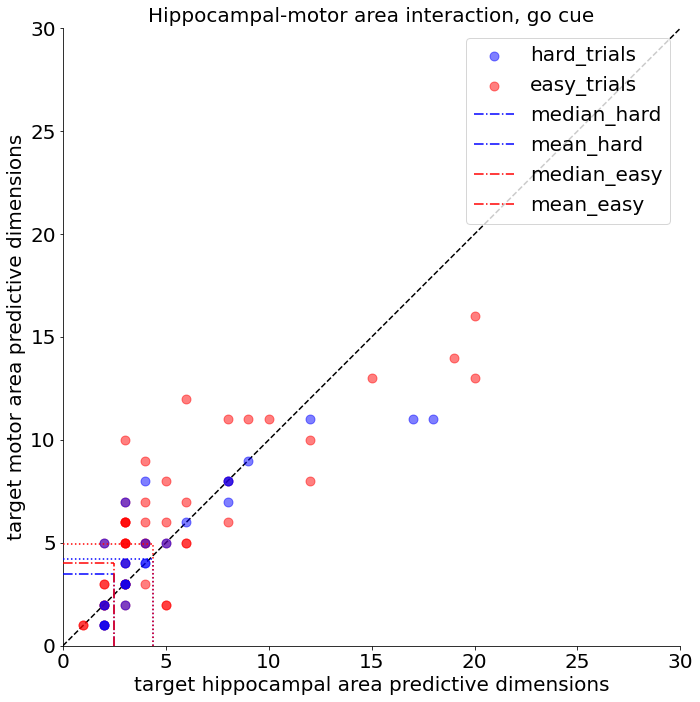

In [ ]:
hard_trial_hh_hm, easy_trial_hh_hm = hard_easy_trial(predictive_dimension_all_hh_hm)
median_value_hard_hh_hm, median_value_easy_hh_hm = some_stat(hard_trial_hh_hm, easy_trial_hh_hm)
mean_value_hard_hh_hm, mean_value_easy_hh_hm = mean_value(hard_trial_hh_hm, easy_trial_hh_hm)
x = np.linspace(0,30)
y = x

fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(hard_trial_hh_hm[:,0]+1,hard_trial_hh_hm[:,1]+1, s = 80, alpha = 0.5, color='b', zorder = 20)
plt.scatter(easy_trial_hh_hm[:,0]+1,easy_trial_hh_hm[:,1]+1, s = 80, alpha = 0.5, color='r', zorder = 10)
plt.plot(x,y,'k--', zorder = 1, label = '_nolegend_')
plt.vlines(median_value_hard_hh_hm[0],0,median_value_hard_hh_hm[1], 'b', 'dashdot', zorder = 10)
plt.hlines(median_value_hard_hh_hm[1],0, median_value_hard_hh_hm[0], 'b', 'dashdot', zorder = 10)
plt.vlines(median_value_easy_hh_hm[0],0,median_value_easy_hh_hm[1], 'r', 'dashdot', zorder = 20)
plt.hlines(median_value_easy_hh_hm[1],0, median_value_easy_hh_hm[0], 'r', 'dashdot', zorder = 20)
plt.vlines(mean_value_hard_hh_hm[0],0,mean_value_hard_hh_hm[1], 'b', 'dotted', zorder = 10)
plt.hlines(mean_value_hard_hh_hm[1],0, mean_value_hard_hh_hm[0], 'b', 'dotted', zorder = 10)
plt.vlines(mean_value_easy_hh_hm[0],0,mean_value_easy_hh_hm[1], 'r', 'dotted', zorder = 40)
plt.hlines(mean_value_easy_hh_hm[1],0, mean_value_easy_hh_hm[0], 'r', 'dotted', zorder = 40)
plt.xlim(0,30)
plt.ylim(0,30)
ax.set_aspect('equal','box')
ax.set_xlabel('target hippocampal area predictive dimensions', fontsize = 20)
ax.set_ylabel('target motor area predictive dimensions', fontsize = 20)
plt.legend(('hard_trials','easy_trials','median_hard', 'mean_hard', 'median_easy', 'mean_easy'),
           loc='upper right', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20)
plt.title('Hippocampal-motor area interaction, go cue', fontsize = 20)

plt.show()

In [ ]:
#@title Loop over all sessions and brain area groups to perform ridge regression and reduced rank regression for each group (CP- MOp) - too little trial, did not perform analysis

caudoputamen     = np.array(('CP'))
primary_motor_area  = np.array(('MOp'))

# How many 10ms spike bins for each type of event
n_bins        = 30

# bins cascade from here

n_cue_bins    = n_bins

n_sessions    = alldat.shape[0]


predictive_dimension_all_cp_mop= []


for i in range(n_sessions):
  session_data = alldat[i]
  
  go_cue          = alldat[i]['gocue']
  response_time  = alldat[i]['response_time']
  feedback_time = alldat[i]['feedback_time']


  spike_to_test = np.array(('correct_1_spikes','correct_0_50_spikes','correct_50_100_spikes','correct_25_50_spikes','correct_25_100_spikes','correct_0_25_spikes'))
  
  predictive_dimension_session_cp_mop = []

  for j in range(len(spike_to_test)):

    spikes_data = session_data[spike_to_test[j]]


    go_cue_spikes = align_spikes_to_events(spikes_data, go_cue, n_cue_bins)

    #for aca-mos interaction

    spike_cp_area = go_cue_spikes[np.isin(session_data['brain_area'],caudoputamen)]
    spike_mop_area = go_cue_spikes[np.isin(session_data['brain_area'],primary_motor_area)]

    if spike_cp_area.size != 0 and spike_mop_area.size != 0:

      spike_cp_area_PSTH_subtracted = PSTH_subtract(spike_cp_area)
      spike_mop_area_PSTH_subtracted = PSTH_subtract(spike_mop_area)

      RR_score_repeat_CPCP = []
      RRR_score_repeat_CPCP= []
      RR_score_repeat_CPMOP = []
      RRR_score_repeat_CPMOP = []

      np.random.seed(42)

      for repeat in range(10):

        #divide into source and target
        cp_source, cp_target, mop_target = divide_source_target(spike_cp_area_PSTH_subtracted, spike_mop_area_PSTH_subtracted)
     
        #cp source cp target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_cp_cp = full_ridge_regression(cp_source, cp_target)
        RR_score_repeat_CPCP.append(ridge_regression_cp_cp)

        #cp source mop target full ridge regression
        warnings.filterwarnings("ignore", category=FutureWarning)
        ridge_regression_cp_mop = full_ridge_regression(cp_source, mop_target)
        RR_score_repeat_CPMOP.append(ridge_regression_cp_mop)

        #cp source cp target reduced rank regression
        RRR_score_CPCP = np.ones(len(range(25)))
        for rank in range(25):
          RRR_score_CPCP[rank] = reduced_rank_regression(cp_source,cp_target,rank = rank)
        RRR_score_repeat_CPCP.append(RRR_score_CPCP)

        #orb source mos target reduced rank regression
        RRR_score_CPMOP = np.ones(len(range(25)))
        for rank in range(25):
          RRR_score_CPMOP[rank] = reduced_rank_regression(cp_source,mop_target,rank = rank)
        RRR_score_repeat_CPMOP.append(RRR_score_CPMOP)
      

      RR_score_repeat_CPCP = np.array(RR_score_repeat_CPCP)
      RRR_score_repeat_CPCP = np.array(RRR_score_repeat_CPCP)
      RR_score_repeat_CPMOP = np.array(RR_score_repeat_CPMOP)
      RRR_score_repeat_CPMOP = np.array(RRR_score_repeat_CPMOP)

      peak_performance_cpcp = np.mean(RR_score_repeat_CPCP)
      reduced_rank_regression_cpcp_score = np.mean(RRR_score_repeat_CPCP, axis = 0)
      peak_performance_cpmop = np.mean(RR_score_repeat_CPMOP)
      reduced_rank_regression_cpmop_score = np.mean(RRR_score_repeat_CPMOP, axis = 0)

      sem_performance_cpcp = np.std(RR_score_repeat_CPCP)
      sem_performance_cpmop = np.std(RR_score_repeat_CPMOP)

          
      predictive_dimension_cpcp_rrr = predictive_dimension(reduced_rank_regression_cpcp_score, peak_performance_cpcp, sem_performance_cpcp)

          
      predictive_dimension_cpmop_rrr = predictive_dimension(reduced_rank_regression_cpmop_score, peak_performance_cpmop, sem_performance_cpmop)


          
      predictive_dimension_session_cp_mop.append([predictive_dimension_cpcp_rrr, predictive_dimension_cpmop_rrr])
  predictive_dimension_all_cp_mop.append(predictive_dimension_session_cp_mop)